In [1]:
pip install pybinding

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pybinding as pb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
import math
import pandas as pd
import seaborn as sb

pb.pltutils.use_style()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Honeycomb lattice definition

In [2]:
def monolayer_graphene():
    a_0 = 0.142  # [nm] carbon-carbon distance
    gamma = 1    # [eV] nearest neighbour hopping

    # create a lattice with 2 primitive vectors
    lat = pb.Lattice(
        a1 = [3*a_0/2, -np.sqrt(3)*a_0/2],
        a2=[3*a_0/2, np.sqrt(3)*a_0/2]
    )

    lat.add_sublattices(
        # name and position
        ('A', [-np.sqrt(3)*a_0/4,0]),
        ('B', [np.sqrt(3)*a_0/4,0])
    )

    lat.add_hoppings(
        # inside the main cell
        ([0,  0], 'A', 'B', -gamma),
        # between neighboring cells
        ([1, 0], 'B', 'A', -gamma),
        ([0, 1], 'B', 'A', -gamma)
    )

    return lat

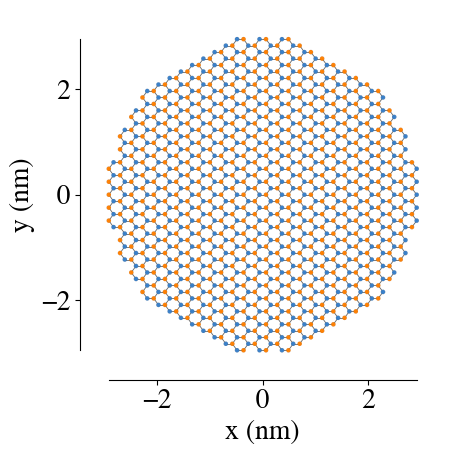

In [39]:
def circle(radius):
    def contains(x, y, z):
        return np.sqrt(x**2 + y**2) < radius
    return pb.FreeformShape(contains, width=[2*radius, 2*radius])

model1 = pb.Model(
    monolayer_graphene().with_min_neighbors(2),
    circle(radius=3)
)
model1.plot()
#model1.shape.plot()
plt.show()

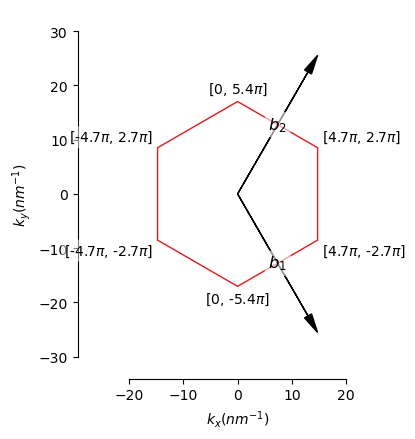

In [18]:
lattice = monolayer_graphene()
lattice.plot_brillouin_zone()

# Uniform circularly-polarized vector potential

In [3]:
def vector_potential(alpha,Omega,t):
    @pb.hopping_energy_modifier
    def function(energy, x1, y1, x2, y2):
        # vector potential along the x-axis
        A_x = alpha*np.cos(Omega*t)
         # vector potential along the y-axis
        A_y = alpha*np.sin(Omega*t)
        #Peierls phase factors
        peierls = A_x*(x1-x2)/a_0 + A_y*(y1-y2)/a_0
         # scale from nanometers to meters (because of x1 and x2)
        return energy * np.exp(1j * peierls)
    return function

# Floquet operator for CP light

In [6]:
a_0 = 0.142
alpha = 1.5
Omega = 4
n = 500
n_a1 = 10
n_a2 = 10

time_mesh = np.linspace(0,2*np.pi/Omega,n+1)
delta_t = 2*np.pi/(n*Omega)

ham_lst = [
    np.zeros((2*n_a1*n_a2,2*n_a1*n_a2))
    for _ in range(n+1)
]
for i in range(n+1):
    model = pb.Model(monolayer_graphene(),pb.primitive(a1=n_a1, a2=n_a2),vector_potential(alpha,Omega,time_mesh[i]))
    ham_lst[i] = model.hamiltonian.todense()
U_lst = [
    np.zeros([2*n_a1*n_a2, 2*n_a1*n_a2], dtype=int)
  for _ in range(n)
]
U = np.eye(2*n_a1*n_a2)

for i in range(n):
    #U_lst[i] = sc.linalg.expm(-1j*delta_t*ham_lst[i])
    U = np.matmul(U,linalg.expm(-1j*delta_t*ham_lst[n-1-i]))

# Floquet Hamiltonian, quasienergies and eigenvectors for CP light

In [7]:
H_F = 1j*linalg.logm(U)*Omega/(2*np.pi)
quasi_energies, vec = linalg.eig(H_F)

In [16]:
qe_sort, vec_sort = zip(*sorted(zip(quasi_energies, np.transpose(vec))))

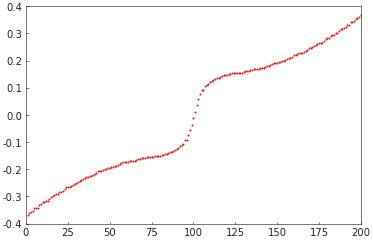

In [8]:
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),quasi_energies,s=1)

# Twisted CP light

In [3]:
def vector_potential_vortex(alpha,Omega,t,m,xi):
    @pb.hopping_energy_modifier
    def function(energy, x1, y1, x2, y2):
        x = (x1+x2)/2
        y = (y1+y2)/2
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)
        #vortex function
        f = ((r/xi)**np.abs(m))*np.exp(-(r/xi)**2)
        # vector potential along the x-axis
        A_x = alpha*f*np.cos(Omega*t + m*phi)
         # vector potential along the y-axis
        A_y = alpha*f*np.sin(Omega*t + m*phi)
        #Peierls phase factors
        peierls = A_x*(x1-x2)/a_0 + A_y*(y1-y2)/a_0
        # the Peierls substitution
        return energy * np.exp(1j * peierls)
    return function

# Ring/disk geometry definition

In [4]:
def ring(inner_radius, outer_radius):
    def contains(x, y, z):
        r = np.sqrt(x**2 + y**2)
        return np.logical_and(inner_radius < r, r < outer_radius)
    return pb.FreeformShape(contains, width=[2*outer_radius, 2*outer_radius])

# Lattice site real-space coordinates

In [5]:
def x_y_lst(m,Omega,alpha,r):
    dr = 3
    xi = 100*a_0
    n = 500

    time_mesh = np.linspace(0,2*np.pi/Omega,n+1)
    delta_t = 2*np.pi/(n*Omega)
    
    model = pb.Model(monolayer_graphene().with_min_neighbors(2),ring(inner_radius=r,outer_radius=r+dr),
                     vector_potential_vortex(alpha,Omega,time_mesh[0],m,xi))
    ham = model.hamiltonian.todense()
    x_lst = model.system.x
    y_lst = model.system.y
    
    return x_lst, y_lst

# Floquet operator for twisted CP light

In [6]:
def time_evolution(m,Omega,alpha,r):
    dr = 3
    xi = 100*a_0
    n = 500

    time_mesh = np.linspace(0,2*np.pi/Omega,n+1)
    delta_t = 2*np.pi/(n*Omega)
    
    model = pb.Model(monolayer_graphene().with_min_neighbors(2),ring(inner_radius=r,outer_radius=r+dr),
                     vector_potential_vortex(alpha,Omega,time_mesh[0],m,xi))
    ham = model.hamiltonian.todense()

    ham_lst = [
        np.zeros((int(np.sqrt(np.size(ham))),int(np.sqrt(np.size(ham)))))
        for _ in range(n+1)
    ]
    ham_lst[0] = ham
    for i in range(n):
        model = pb.Model(monolayer_graphene().with_min_neighbors(2),ring(inner_radius=r,outer_radius=r+dr),
                         vector_potential_vortex(alpha,Omega,time_mesh[i+1],m,xi))
        ham_lst[i+1] = model.hamiltonian.todense()
    U_lst = [
        np.zeros([int(np.sqrt(np.size(ham))),int(np.sqrt(np.size(ham)))], dtype=int)
      for _ in range(n)
    ]
    U = np.eye(int(np.sqrt(np.size(ham))))

    for i in range(n):
        U = np.matmul(U,linalg.expm(-1j*delta_t*ham_lst[n-1-i]))
    return U

# Parameters

In [24]:
a_0 = 0.142
Omega = 1
alpha = 22.3
m = 1
r = 0.

# Function calls

In [25]:
x_lst, y_lst = x_y_lst(m,Omega,alpha,r)
#first half is A sublattice, second half is B sublattice

In [9]:
U = time_evolution(m,Omega,alpha,r)

U_real_df = pd.DataFrame(data=np.real(U))
U_imag_df = pd.DataFrame(data=np.imag(U))

# Export/import data files

In [25]:
U_real_df.to_csv('U_real,Omega=2.4,alpha=0.93,m=0(disk).csv')
U_imag_df.to_csv('U_imag,Omega=2.4,alpha=0.93,m=0(disk).csv')

In [9]:
U_real_import = pd.read_csv('U_real,Omega=2.4,alpha=0.92,m=0(disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=2.4,alpha=0.92,m=0(disk).csv').to_numpy()[:,1:]

In [154]:
U_real_df.to_csv('U_real,Omega=2.8,alpha=4,r_c=1.8(disk).csv')
U_imag_df.to_csv('U_imag,Omega=2.8,alpha=4,r_c=1.8(disk).csv')

In [10]:
U_real_import = pd.read_csv('U_real,Omega=2.8,alpha=4,r_c=1.8(disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=2.8,alpha=4,r_c=1.8(disk).csv').to_numpy()[:,1:]

In [20]:
U_real_df.to_csv('U_real,Omega=2.8,alpha=4,r_c=1.8.csv')
U_imag_df.to_csv('U_imag,Omega=2.8,alpha=4,r_c=1.8.csv')

In [80]:
U_real_import = pd.read_csv('U_real,Omega=2.8,alpha=4,r_c=1.8.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=2.8,alpha=4,r_c=1.8.csv').to_numpy()[:,1:]

In [10]:
U_real_df.to_csv('U_real,Omega=2.8,alpha=4,r_c=1.8,m=-1.csv')
U_imag_df.to_csv('U_imag,Omega=2.8,alpha=4,r_c=1.8,m=-1.csv')

In [25]:
U_real_import = pd.read_csv('U_real,Omega=2.8,alpha=4,r_c=1.8,m=-1.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=2.8,alpha=4,r_c=1.8,m=-1.csv').to_numpy()[:,1:]

In [33]:
U_real_df.to_csv('U_real,Omega=5.8,alpha=3,r_c=1.8.csv')
U_imag_df.to_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8.csv')

In [34]:
U_real_import = pd.read_csv('U_real,Omega=5.8,alpha=3,r_c=1.8.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8.csv').to_numpy()[:,1:]

In [265]:
U_real_df.to_csv('U_real,Omega=5.8,alpha=3,r_c=1.8(disk).csv')
U_imag_df.to_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8(disk).csv')

In [9]:
U_real_import = pd.read_csv('U_real,Omega=5.8,alpha=3,r_c=1.8(disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8(disk).csv').to_numpy()[:,1:]

In [35]:
U_real_df.to_csv('U_real,Omega=5.8,alpha=3,r_c=1.8,m=-1.csv')
U_imag_df.to_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8,m=-1.csv')

In [43]:
U_real_import = pd.read_csv('U_real,Omega=5.8,alpha=3,r_c=1.8,m=-1.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8,m=-1.csv').to_numpy()[:,1:]

In [312]:
U_real_df.to_csv('U_real,Omega=5.8,alpha=3,r_c=1.8,m=-1(disk).csv')
U_imag_df.to_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8,m=-1(disk).csv')

In [313]:
U_real_import = pd.read_csv('U_real,Omega=5.8,alpha=3,r_c=1.8,m=-1(disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=5.8,alpha=3,r_c=1.8,m=-1(disk).csv').to_numpy()[:,1:]

In [ ]:
U_real_df.to_csv('U_real,Omega=1,alpha=4,r_c=2.3.csv')
U_imag_df.to_csv('U_imag,Omega=1,alpha=4,r_c=2.3.csv')

In [52]:
U_real_import = pd.read_csv('U_real,Omega=1,alpha=4,r_c=2.3.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=1,alpha=4,r_c=2.3.csv').to_numpy()[:,1:]

In [19]:
U_real_df.to_csv('U_real,Omega=1,alpha=3.2,r_c=2.8(disk).csv')
U_imag_df.to_csv('U_imag,Omega=1,alpha=3.2,r_c=2.8(disk).csv')

In [20]:
U_real_import = pd.read_csv('U_real,Omega=1,alpha=3.2,r_c=2.8(disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=1,alpha=3.2,r_c=2.8(disk).csv').to_numpy()[:,1:]

In [10]:
U_real_df.to_csv('U_real,Omega=1,alpha=22.3,r_c=2.csv')
U_imag_df.to_csv('U_imag,Omega=1,alpha=22.3,r_c=2.csv')

In [62]:
U_real_import = pd.read_csv('U_real,Omega=1,alpha=22.3,r_c=2.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=1,alpha=22.3,r_c=2.csv').to_numpy()[:,1:]

In [328]:
U_real_df.to_csv('U_real,Omega=1,alpha=22.3,r_c=2(disk).csv')
U_imag_df.to_csv('U_imag,Omega=1,alpha=22.3,r_c=2(disk).csv')

In [26]:
U_real_import = pd.read_csv('U_real,Omega=1,alpha=22.3,r_c=2(disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=1,alpha=22.3,r_c=2(disk).csv').to_numpy()[:,1:]

In [50]:
U_real_df.to_csv('U_real,Omega=1,alpha=22.3,r_c=2,m=-1.csv')
U_imag_df.to_csv('U_imag,Omega=1,alpha=22.3,r_c=2,m=-1.csv')

In [71]:
U_real_import = pd.read_csv('U_real,Omega=1,alpha=22.3,r_c=2,m=-1.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=1,alpha=22.3,r_c=2,m=-1.csv').to_numpy()[:,1:]

In [346]:
U_real_df.to_csv('U_real,Omega=1,alpha=22.3,r_c=2,m=-1(disk).csv')
U_imag_df.to_csv('U_imag,Omega=1,alpha=22.3,r_c=2,m=-1(disk).csv')

In [347]:
U_real_import = pd.read_csv('U_real,Omega=1,alpha=22.3,r_c=2,m=-1(disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=1,alpha=22.3,r_c=2,m=-1(disk).csv').to_numpy()[:,1:]

In [85]:
U_real_df.to_csv('U_real,Omega=2.01482,alpha=20,r_c=1.3.csv')
U_imag_df.to_csv('U_imag,Omega=2.01482,alpha=20,r_c=1.3.csv')

In [115]:
U_real_import = pd.read_csv('U_real,Omega=2.01482,alpha=20,r_c=1.3.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=2.01482,alpha=20,r_c=1.3.csv').to_numpy()[:,1:]

In [64]:
U_real_df.to_csv('U_real,Omega=2.01482,alpha=20,r_c=1.3,m=-1.csv')
U_imag_df.to_csv('U_imag,Omega=2.01482,alpha=20,r_c=1.3,m=-1.csv')

In [65]:
U_real_import = pd.read_csv('U_real,Omega=2.01482,alpha=20,r_c=1.3,m=-1.csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=2.01482,alpha=20,r_c=1.3,m=-1.csv').to_numpy()[:,1:]

In [137]:
U_real_df.to_csv('U_real,Omega=2.01482,alpha=9,r_c=2.8 (disk).csv')
U_imag_df.to_csv('U_imag,Omega=2.01482,alpha=9,r_c=2.8 (disk).csv')

In [9]:
U_real_import = pd.read_csv('U_real,Omega=2.01482,alpha=9,r_c=2.8 (disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=2.01482,alpha=9,r_c=2.8 (disk).csv').to_numpy()[:,1:]

In [10]:
U_real_df.to_csv('U_real,Omega=0.7,alpha=25.6,r_c=3.55,m=2 (disk).csv')
U_imag_df.to_csv('U_imag,Omega=0.7,alpha=25.6,r_c=3.55,m=2 (disk).csv')

In [9]:
U_real_import = pd.read_csv('U_real,Omega=0.7,alpha=25.6,r_c=3.55,m=2 (disk).csv').to_numpy()[:,1:]
U_imag_import = pd.read_csv('U_imag,Omega=0.7,alpha=25.6,r_c=3.55,m=2 (disk).csv').to_numpy()[:,1:]

# Floquet Hamiltonian, quasienergies and eigenvectors for twisted CP light

In [27]:
U_import = U_real_import + 1j*U_imag_import
H_F = 1j*linalg.logm(U_import)*Omega/(2*np.pi)
quasi_energies, vec = linalg.eig(H_F)

In [28]:
qe_sort, vec_sort = zip(*sorted(zip(np.abs(quasi_energies), np.transpose(vec))))

# Real-space bound state probability density

In [29]:
k=50
prob_density = [
        [0+0*1j]*np.size(qe_sort)
        for _ in range(k)
]
for i in range(k):
    for j in range(np.size(qe_sort)):
        #prob_density[i][j] = np.conjugate(vec_sort[i][j])*(vec_sort[i][j])
        prob_density[i][j] = np.conjugate(vec_sort[-i-1][j])*vec_sort[-i-1][j]
    prob_density[i] = prob_density[i]/max(prob_density[i])

# Separate real-space edge BS from bulk BS

In [32]:
b=0
e=0
bulk_BS = [
        [0+0*1j]*np.size(qe_sort)
        for _ in range(k)
]
bulk_eval = [0]*k
edge_BS = [
        [0+0*1j]*np.size(qe_sort)
        for _ in range(k)
]
edge_eval = [0]*k

for j in range(k):
    u=0
    for i in range(np.size(x_lst)):
        if ((2.5<=np.sqrt(x_lst[i]**2 + y_lst[i]**2)<=3)&(prob_density[j][i]>=0.5)):
            u+=1
            break
    if u==0:
        #bulk_BS[b] = vec_sort[j]
        #bulk_eval[j] = qe_sort[j]
        bulk_BS[b] = vec_sort[-j-1]
        bulk_eval[j] = qe_sort[-j-1]
        b+=1
    if u==1:
        #edge_BS[e] = vec_sort[j]
        #edge_eval[j] = qe_sort[j]
        edge_BS[e] = vec_sort[-j-1]
        edge_eval[j] = qe_sort[-j-1]
        e+=1  

prob_bulk = [
        [0+0*1j]*np.size(qe_sort)
        for _ in range(b)
]
for i in range(b):
    for j in range(np.size(qe_sort)):
        prob_bulk[i][j] = np.conjugate(bulk_BS[i][j])*bulk_BS[i][j]
    prob_bulk[i] = prob_bulk[i]/max(prob_bulk[i])
prob_edge = [
        [0+0*1j]*np.size(qe_sort)
        for _ in range(e)
]
for i in range(e):
    for j in range(np.size(qe_sort)):
        prob_edge[i][j] = np.conjugate(edge_BS[i][j])*edge_BS[i][j]
    prob_edge[i] = prob_edge[i]/max(prob_edge[i])

# Angular momentum of bulk BS

In [14]:
Nm = 21
ang_mom = np.linspace(-5,5,Nm)
vec_m_A = [
    [0+0*1j]*Nm
    for _ in range(b)
]
vec_m_B = [
    [0+0*1j]*Nm
    for _ in range(b)
]
for u in range(b):
    for i in range(Nm):
        for j in range(int(np.size(bulk_BS[0])/2)):
            vec_m_A[u][i] = vec_m_A[u][i] + np.exp(1j*ang_mom[i]*np.arctan2(y_lst[j],x_lst[j]))*bulk_BS[u][j]
            vec_m_B[u][i] = vec_m_B[u][i] + np.exp(1j*ang_mom[i]*np.arctan2(y_lst[int(np.size(bulk_BS[0])/2)+j],x_lst[int(np.size(bulk_BS[0])/2)+j]))*bulk_BS[u][int(np.size(bulk_BS[0])/2)+j]

prob_den_m_A = [
    [0+0*1j]*Nm
    for _ in range(b)
]
prob_den_m_B = [
    [0+0*1j]*Nm
    for _ in range(b)
]
for u in range(b):
    for i in range(Nm):
        prob_den_m_A[u][i] = np.real(np.conjugate(vec_m_A[u][i])*vec_m_A[u][i])
        prob_den_m_B[u][i] = np.real(np.conjugate(vec_m_B[u][i])*vec_m_B[u][i])
    prob_den_m_A[u] = prob_den_m_A[u]/max(prob_den_m_A[u])
    prob_den_m_B[u] = prob_den_m_B[u]/max(prob_den_m_B[u])

# $k$-space bound state probability density

In [138]:
Nk = 49
kx = np.linspace(-4.7*np.pi,4.7*np.pi,Nk)
ky = np.linspace(-5.4*np.pi,5.4*np.pi,Nk)

vec_k_A = [
    [0+0*1j]*(Nk*Nk)
    for _ in range(k)
]
vec_k_B = [
    [0+0*1j]*(Nk*Nk)
    for _ in range(k)
]

for q in range(b):
    for i in range(Nk):
        for j in range(Nk):
            for l in range(int(np.size(bulk_BS[0])/2)):
                #vec_k_A[q][i*Nk+j] = vec_k_A[q][i*Nk+j] + np.exp(1j*(kx[i]*x_lst[l]+ky[j]*y_lst[l]))*bulk_BS[q][l]
                vec_k_A[q][i*Nk+j] = vec_k_A[q][i*Nk+j] + np.exp(1j*(kx[j]*x_lst[l]+ky[i]*y_lst[l]))*bulk_BS[q][l]
                #vec_k_B[q][i*Nk+j] = vec_k_B[q][i*Nk+j] + np.exp(1j*(kx[i]*x_lst[int(np.size(vec_sort[0])/2)+l]+ky[j]*y_lst[int(np.size(vec_sort[0])/2)+l]))*bulk_BS[q][int(np.size(bulk_BS[0])/2)+l]
                vec_k_B[q][i*Nk+j] = vec_k_B[q][i*Nk+j] + np.exp(1j*(kx[j]*x_lst[int(np.size(vec_sort[0])/2)+l]+ky[i]*y_lst[int(np.size(vec_sort[0])/2)+l]))*bulk_BS[q][int(np.size(bulk_BS[0])/2)+l]

prob_den = [
    [0+0*1j]*(Nk*Nk)
    for _ in range(k)
]
prob_density_A = [
    [0+0*1j]*(Nk*Nk)
    for _ in range(k)
]
prob_density_B = [
    [0+0*1j]*(Nk*Nk)
    for _ in range(k)
]

for i in range(b):
    for j in range(Nk*Nk):
        #prob_den[i][j] = np.real(np.conjugate(vec_k_A[i][j]+vec_k_B[i][j])*(vec_k_A[i][j]+vec_k_B[i][j]))
        prob_density_A[i][j] = np.real(np.conjugate(vec_k_A[i][j])*vec_k_A[i][j])
        prob_density_B[i][j] = np.real(np.conjugate(vec_k_B[i][j])*vec_k_B[i][j])
    prob_density_A[i] = prob_density_A[i]/max(prob_density_A[i])
    prob_density_B[i] = prob_density_B[i]/max(prob_density_B[i])

Kx = [0]*(Nk*Nk)
Ky = [0]*(Nk*Nk)
for i in range(Nk):
    for j in range(Nk):
        Kx[j+i*Nk] = kx[j]
        Ky[j+i*Nk] = ky[i]

# $\Gamma$-point BS at $\epsilon=0$; $\Omega=2.4, \alpha=0.92, m=0$ with disk geometry

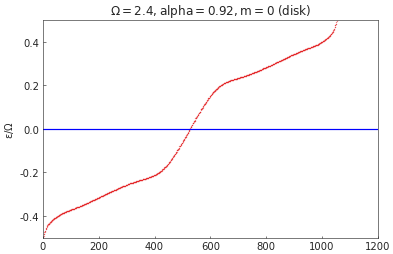

In [14]:
plt.title('$\Omega=2.4, alpha = 0.92, m = 0\;(disk)$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.axhline(y = 0, color = 'b', linestyle = '-')
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(np.real(quasi_energies))/Omega,s=0.05)

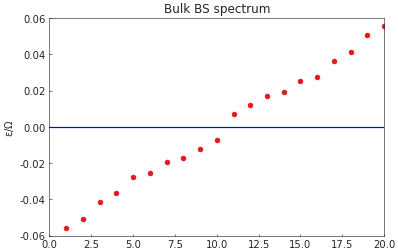

In [15]:
plt.title('Bulk BS spectrum')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.06,0.06)
plt.axhline(y = 0, color = 'b', linestyle = '-')
plt.scatter(np.linspace(1,b,b),np.sort(np.append(-np.array(bulk_eval[:b:2]),np.array(bulk_eval[:b:2])))/Omega,s=20)

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

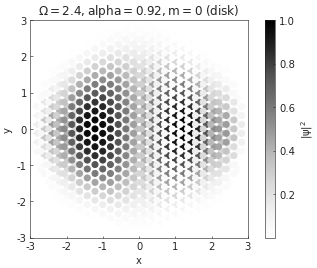

In [16]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[0],cmap='Greys')
plt.title('$\Omega=2.4, alpha = 0.92, m = 0\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

# $\Gamma$-point BS at $\epsilon=0$; $\Omega=2.8, \alpha=4, r_c=1.8$ with disk geometry

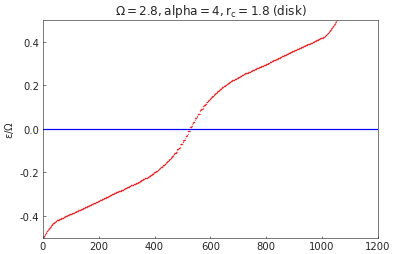

In [219]:
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8\;(disk)$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.axhline(y = 0, color = 'b', linestyle = '-')
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(np.real(quasi_energies))/Omega,s=0.05)

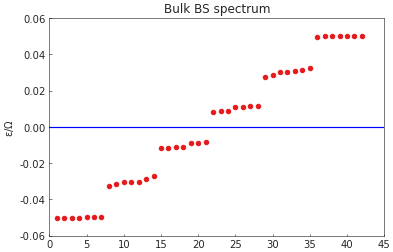

In [218]:
plt.title('Bulk BS spectrum')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.06,0.06)
plt.axhline(y = 0, color = 'b', linestyle = '-')
plt.scatter(np.linspace(1,b,b),np.sort(np.append(-np.array(bulk_eval[:b:2]),np.array(bulk_eval[:b:2])))/Omega,s=20)

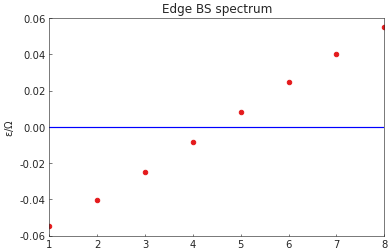

In [223]:
plt.title('Edge BS spectrum')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.06,0.06)
plt.axhline(y = 0, color = 'b', linestyle = '-')
plt.scatter(np.linspace(1,e,e),np.sort(np.append(-np.array(edge_eval[:e:2]),np.array(edge_eval[:e:2])))/Omega,s=20)

<function matplotlib.pyplot.show(close=None, block=None)>

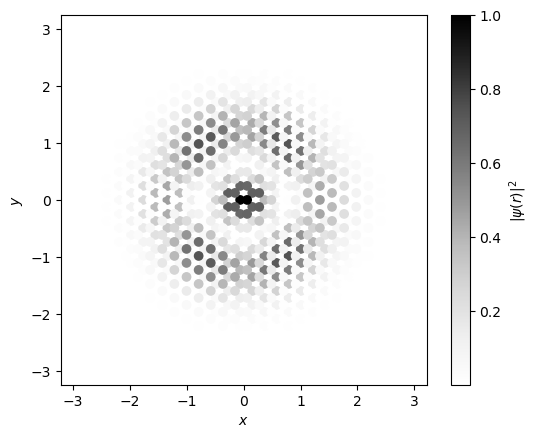

In [30]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[0],cmap='Greys')
#plt.title(r'$\Omega=2.8, \alpha = 4, r_c = 1.8\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar()
cbar.set_label(r'$|\psi(r)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

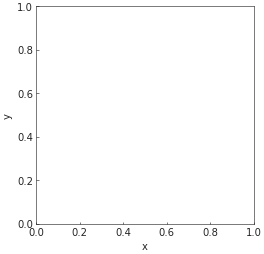

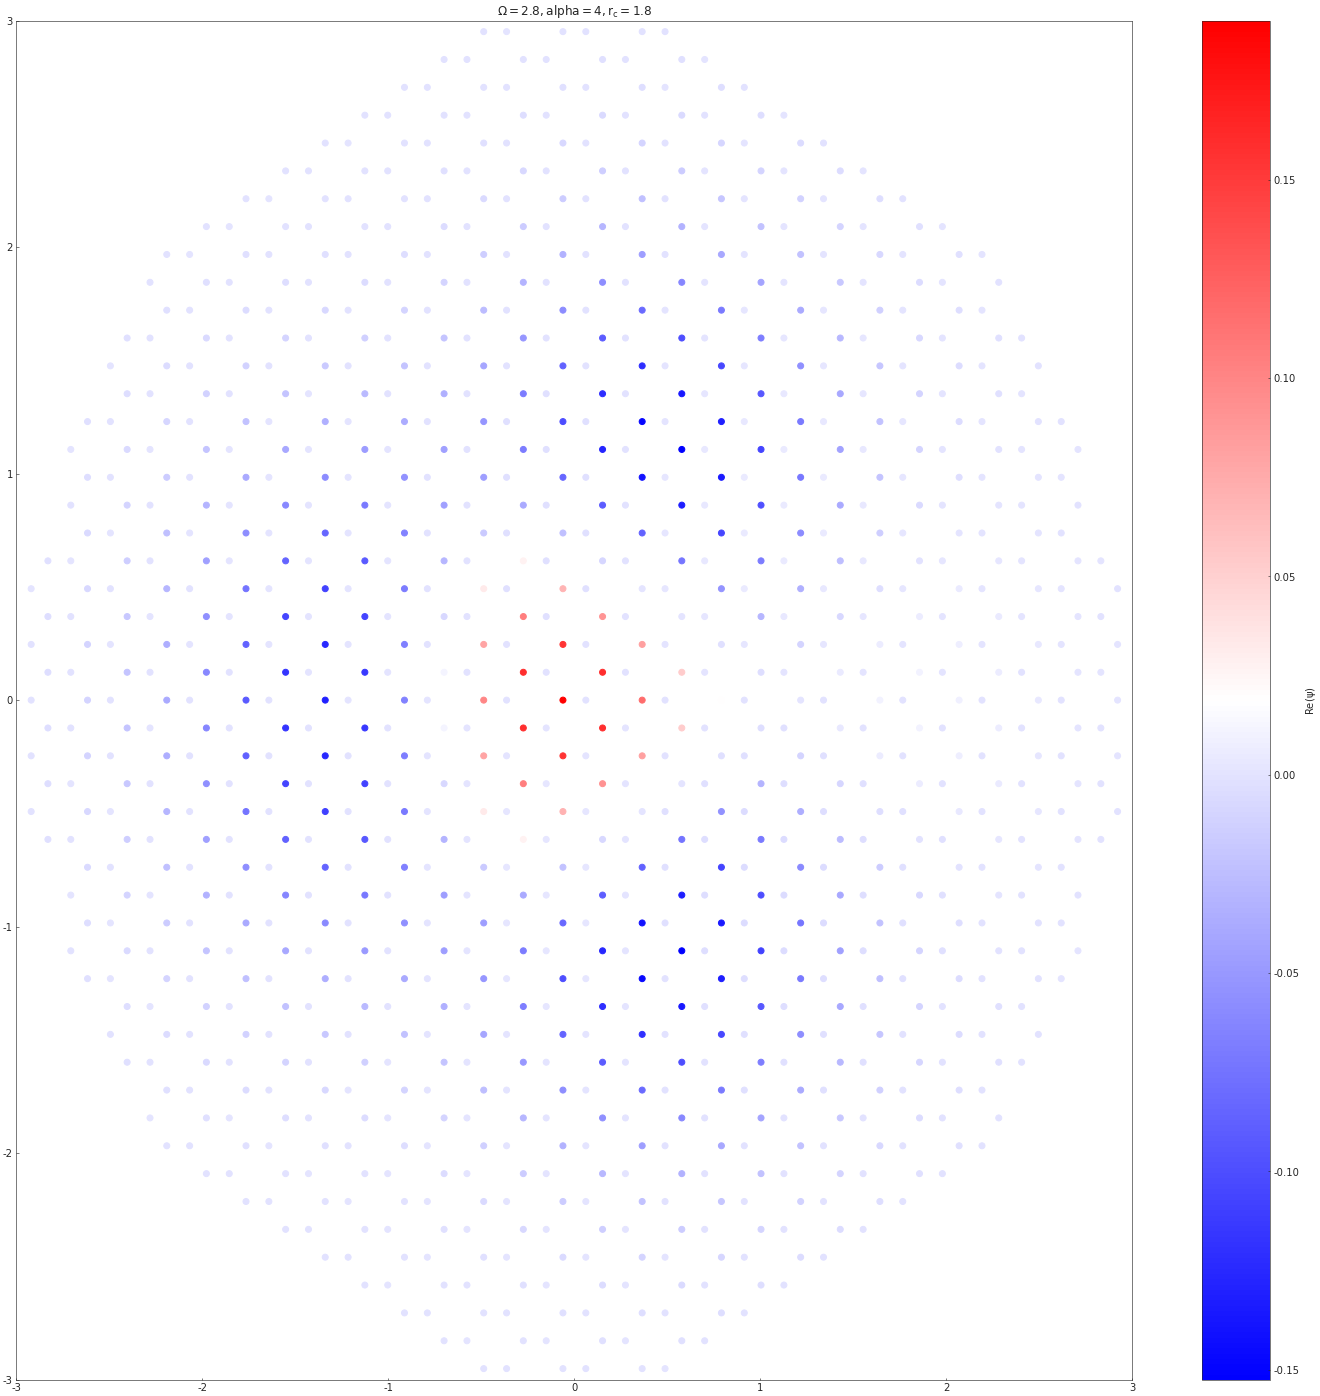

In [399]:
ax = plt.subplot()
plt.figure(figsize=(25,25))
plt.scatter(x_lst,y_lst,c=np.imag(bulk_BS[0]+bulk_BS[1]),cmap='bwr')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$Re(\psi)$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

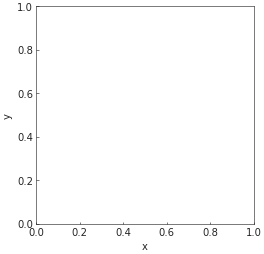

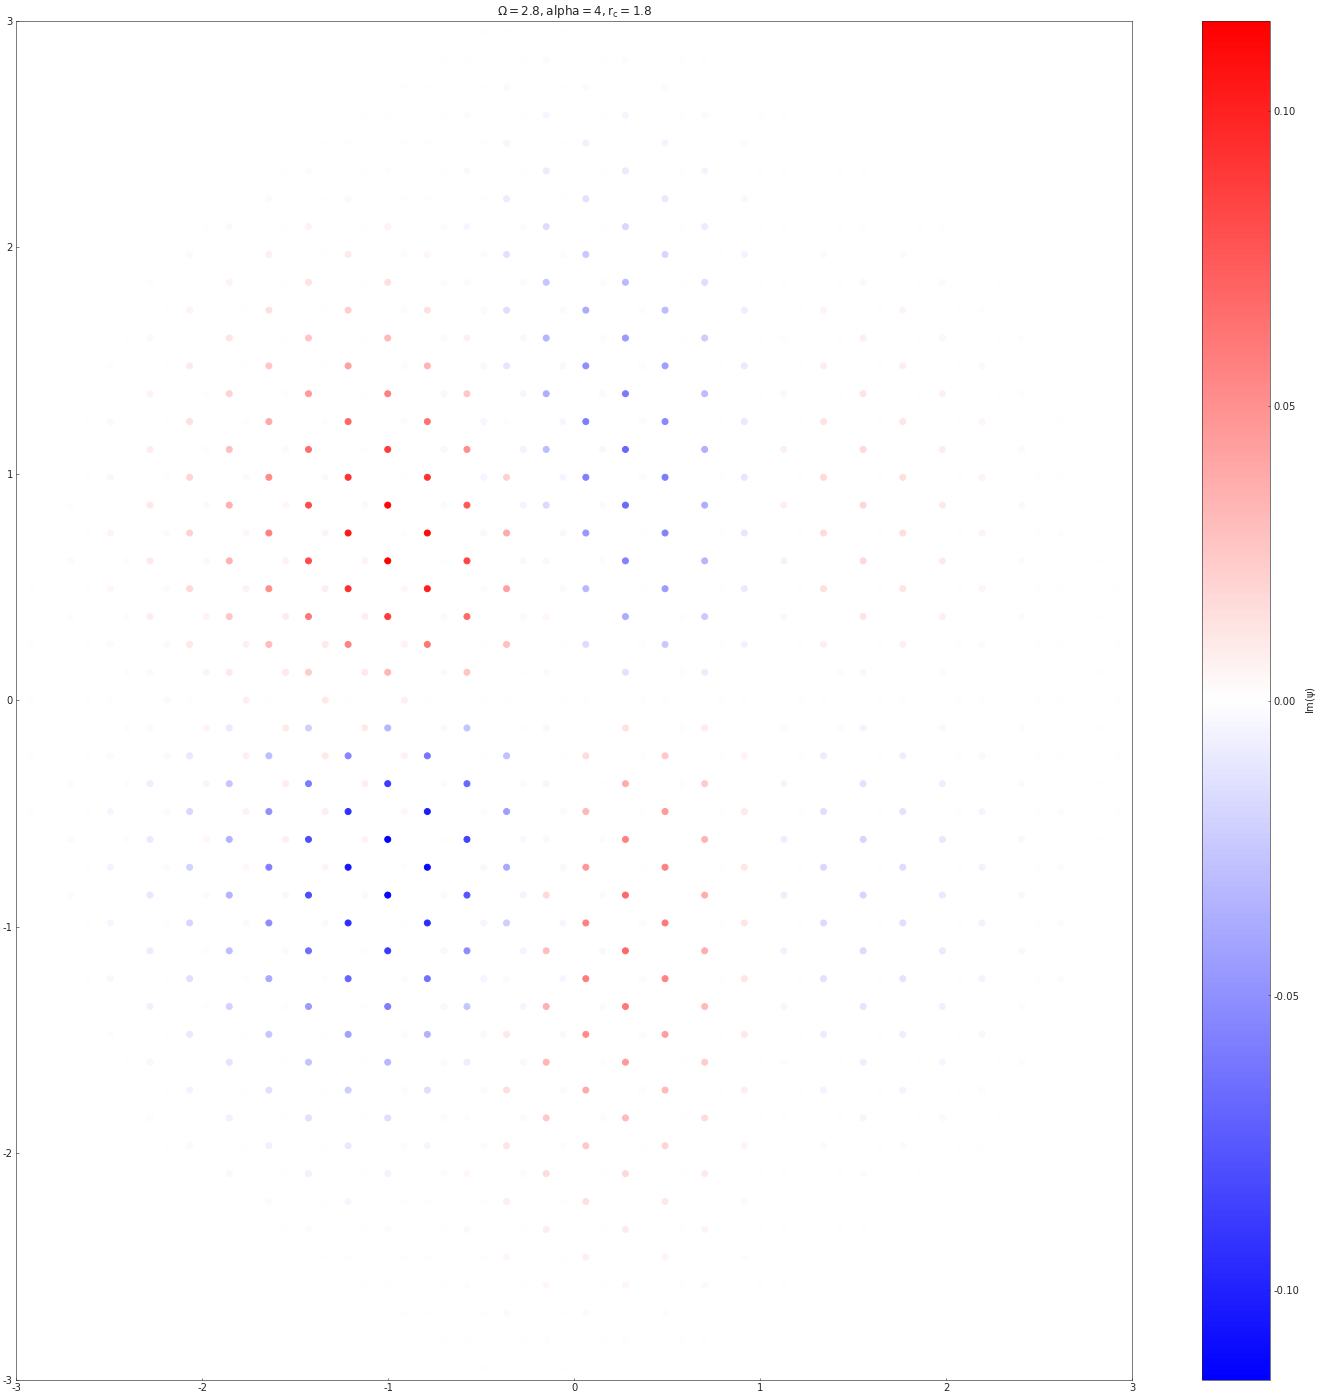

In [400]:
ax = plt.subplot()
plt.figure(figsize=(25,25))
plt.scatter(x_lst,y_lst,c=np.imag(bulk_BS[0]+bulk_BS[1]),cmap='bwr')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$Im(\psi)$')
plt.show

In [67]:
for x in range(b):
    if np.real(np.dot(np.conjugate(bulk_BS[x]),np.matmul(H_F,bulk_BS[x])))<0:
        print(x,np.dot(np.conjugate(bulk_BS[x]),np.matmul(H_F,bulk_BS[x])))

0 (-0.023227726218218434-1.3821490610008147e-14j)
2 (-0.024114771991119954-1.508327154581962e-14j)
4 (-0.024928904156758566-1.5588713046105207e-14j)
6 (-0.030457345289049705-1.5050677718009275e-14j)
8 (-0.030974875237626043-1.431705231799696e-14j)
10 (-0.031912512554260926-1.5449501487158068e-14j)
13 (-0.032367585441617705-1.449876460210553e-14j)
14 (-0.07646549726531193-1.6222700266466106e-14j)
16 (-0.08038587157632278-1.3934254412210217e-14j)
19 (-0.08541725421507954-1.3014356302701313e-14j)
20 (-0.0856051497720147-1.4197288635518779e-14j)
22 (-0.08589835731991687-1.3828445597538052e-14j)
25 (-0.08784837893455388-1.3231603313013096e-14j)
27 (-0.09127401372559249-1.2698460447220505e-14j)
29 (-0.13949685743250517-1.3961488215530338e-14j)
31 (-0.13978339277879606-1.2114441394484032e-14j)
32 (-0.13991595623263703-1.3801459974871477e-14j)
34 (-0.1401722783188097-1.3579415369946446e-14j)
36 (-0.1404319686507211-1.595902229811763e-14j)
39 (-0.14045319128991102-1.5333437644593495e-14j)
40 (-

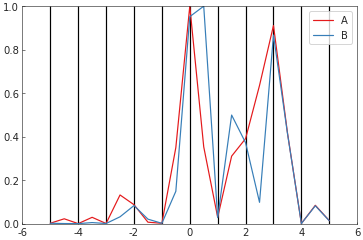

In [81]:
y=0
plt.plot(ang_mom,prob_den_m_A[y],label='A')
plt.plot(ang_mom,prob_den_m_B[y],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

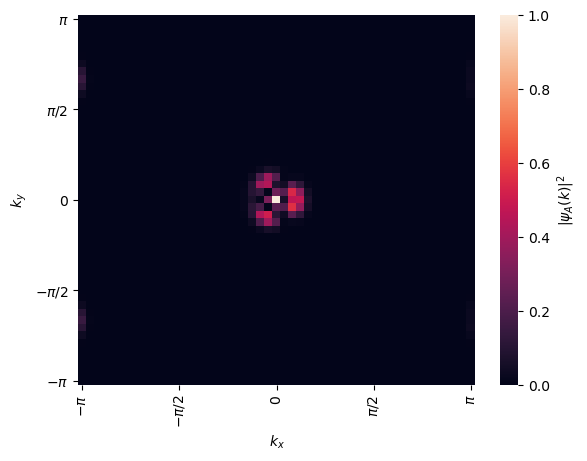

In [39]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky,cbar_kws={'label': r'$|\psi_A(k)|^2$'})
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels([r'$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels([r'$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

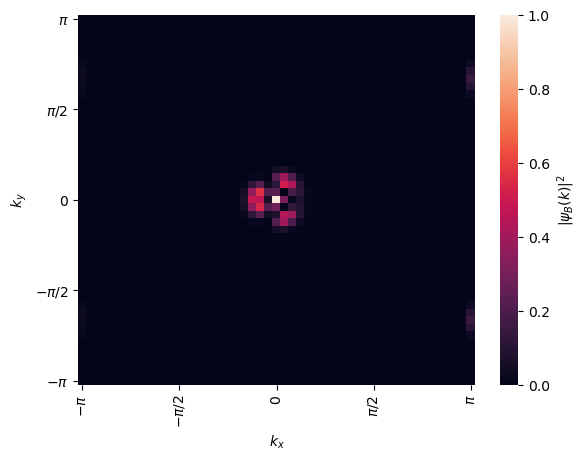

In [40]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky,cbar_kws={'label': r'$|\psi_B(k)|^2$'})
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels([r'$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels([r'$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

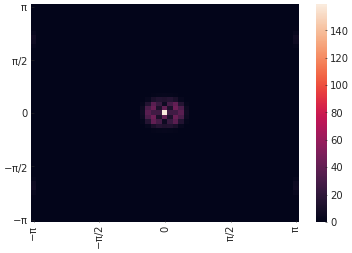

In [64]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

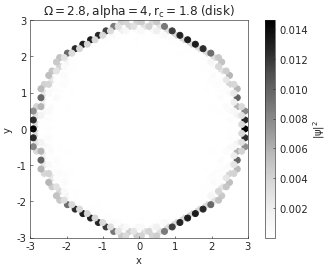

In [30]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[2],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

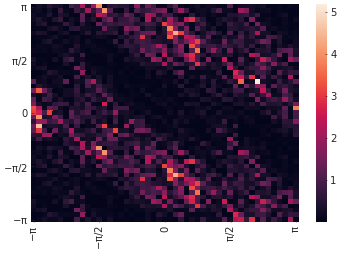

In [33]:
ax = sb.heatmap(np.array(prob_density_A[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

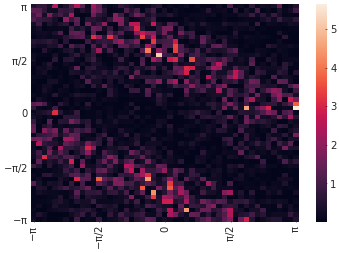

In [34]:
ax = sb.heatmap(np.array(prob_density_B[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

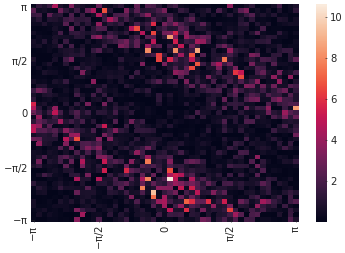

In [35]:
ax = sb.heatmap(np.array(prob_den[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

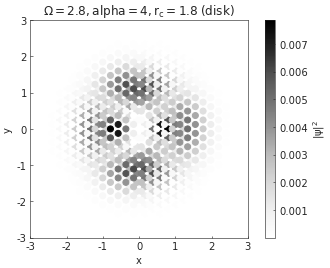

In [31]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[4],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

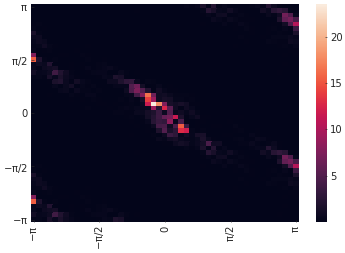

In [54]:
ax = sb.heatmap(np.array(prob_density_A[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

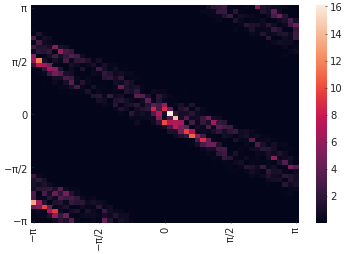

In [55]:
ax = sb.heatmap(np.array(prob_density_B[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

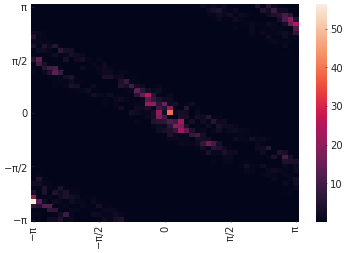

In [56]:
ax = sb.heatmap(np.array(prob_den[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

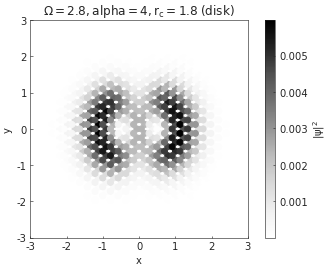

In [32]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[6],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

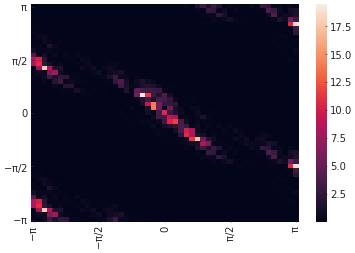

In [57]:
ax = sb.heatmap(np.array(prob_density_A[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

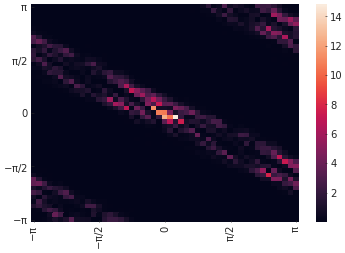

In [58]:
ax = sb.heatmap(np.array(prob_density_B[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

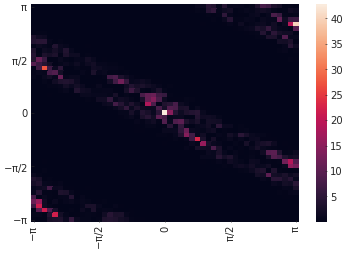

In [59]:
ax = sb.heatmap(np.array(prob_den[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

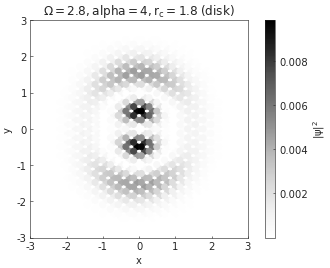

In [33]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[8],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

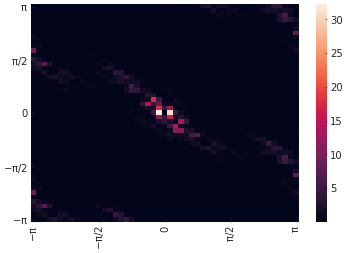

In [60]:
ax = sb.heatmap(np.array(prob_density_A[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

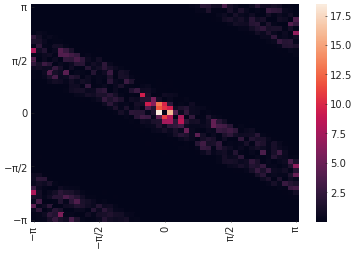

In [61]:
ax = sb.heatmap(np.array(prob_density_B[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

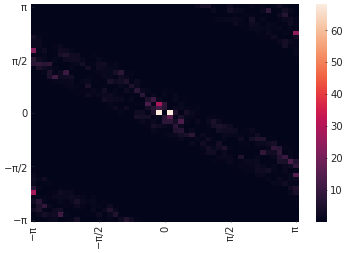

In [62]:
ax = sb.heatmap(np.array(prob_den[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $\Gamma$-point BS at $\epsilon=0$; $\Omega=2.8, \alpha=4, r_c=1.8$ with annular geometry

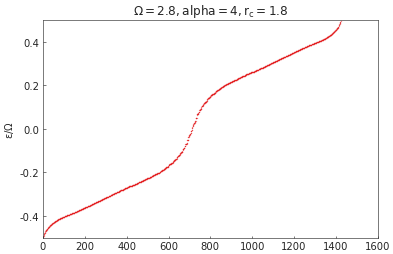

In [71]:
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(np.real(quasi_energies))/Omega,s=0.05)

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

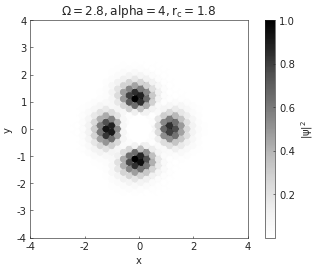

In [15]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

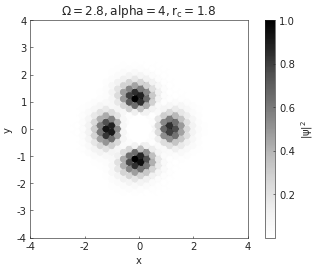

In [121]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[0],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

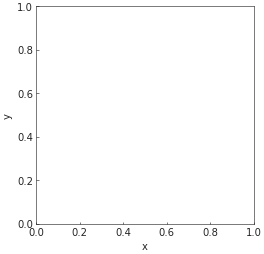

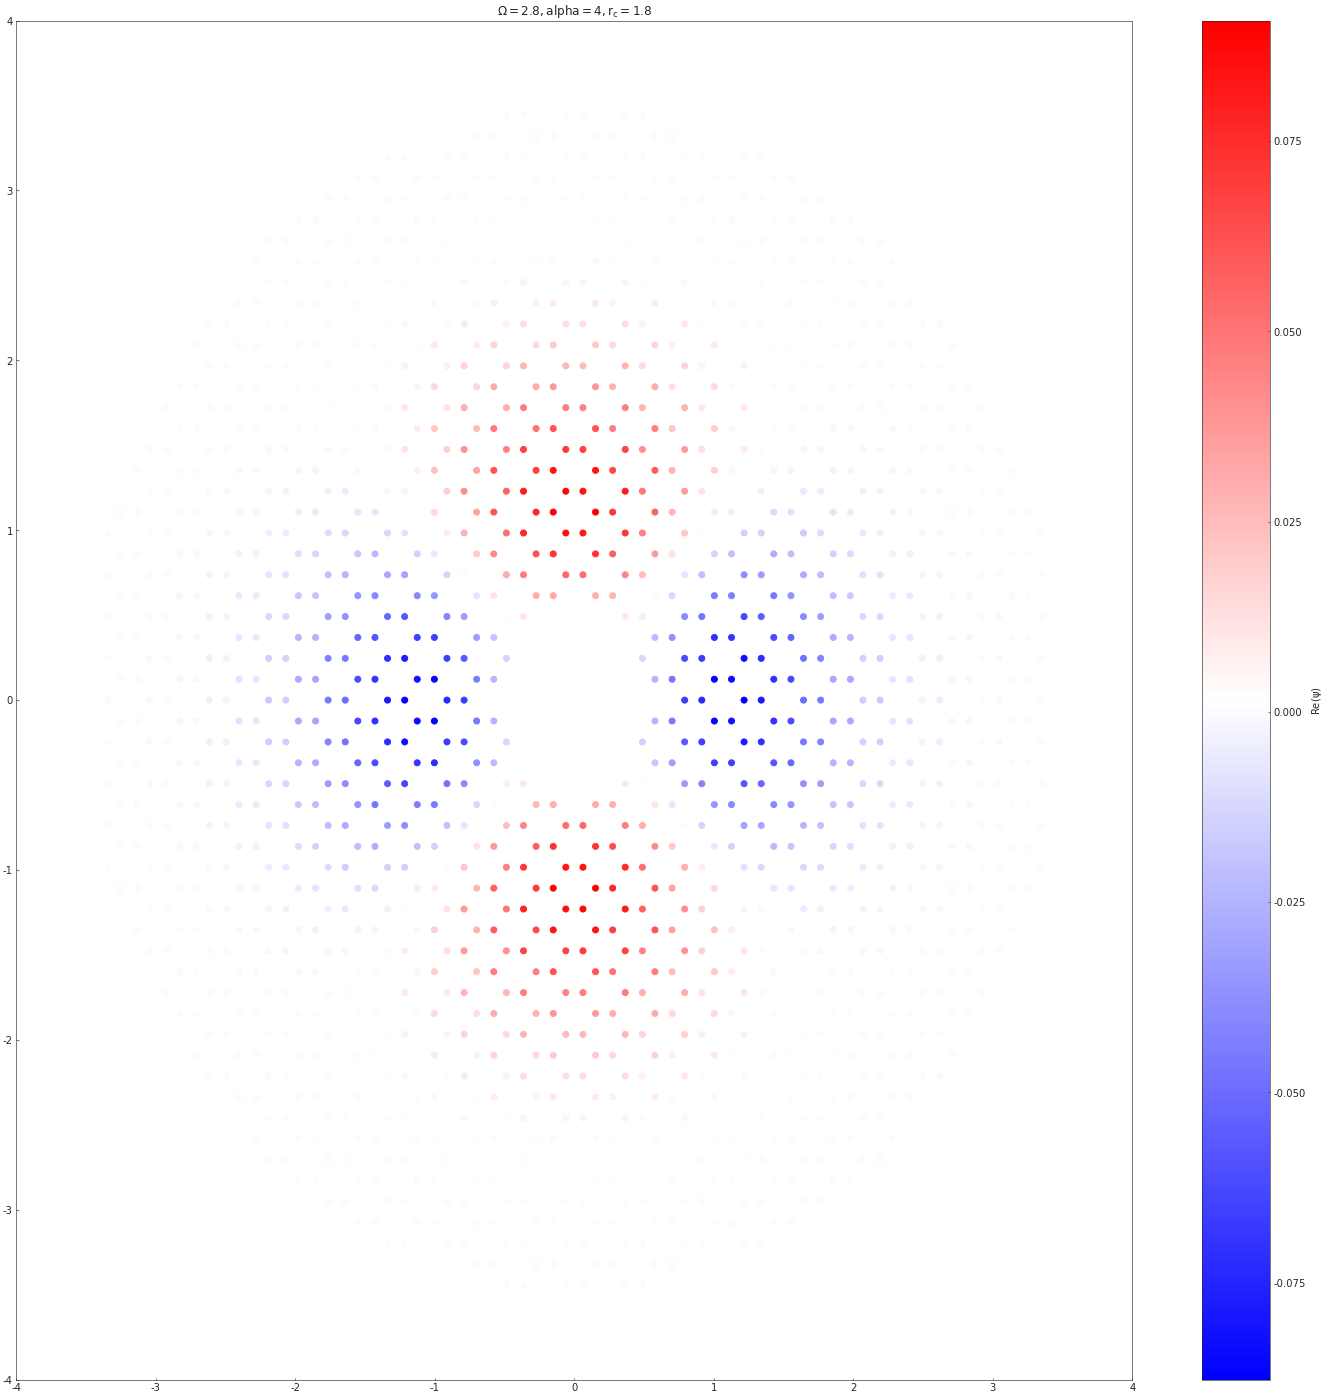

In [101]:
ax = plt.subplot()
plt.figure(figsize=(25,25))
plt.scatter(x_lst,y_lst,c=np.real(bulk_BS[0]),cmap='bwr')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$Re(\psi)$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

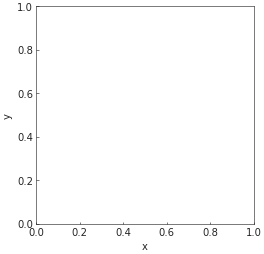

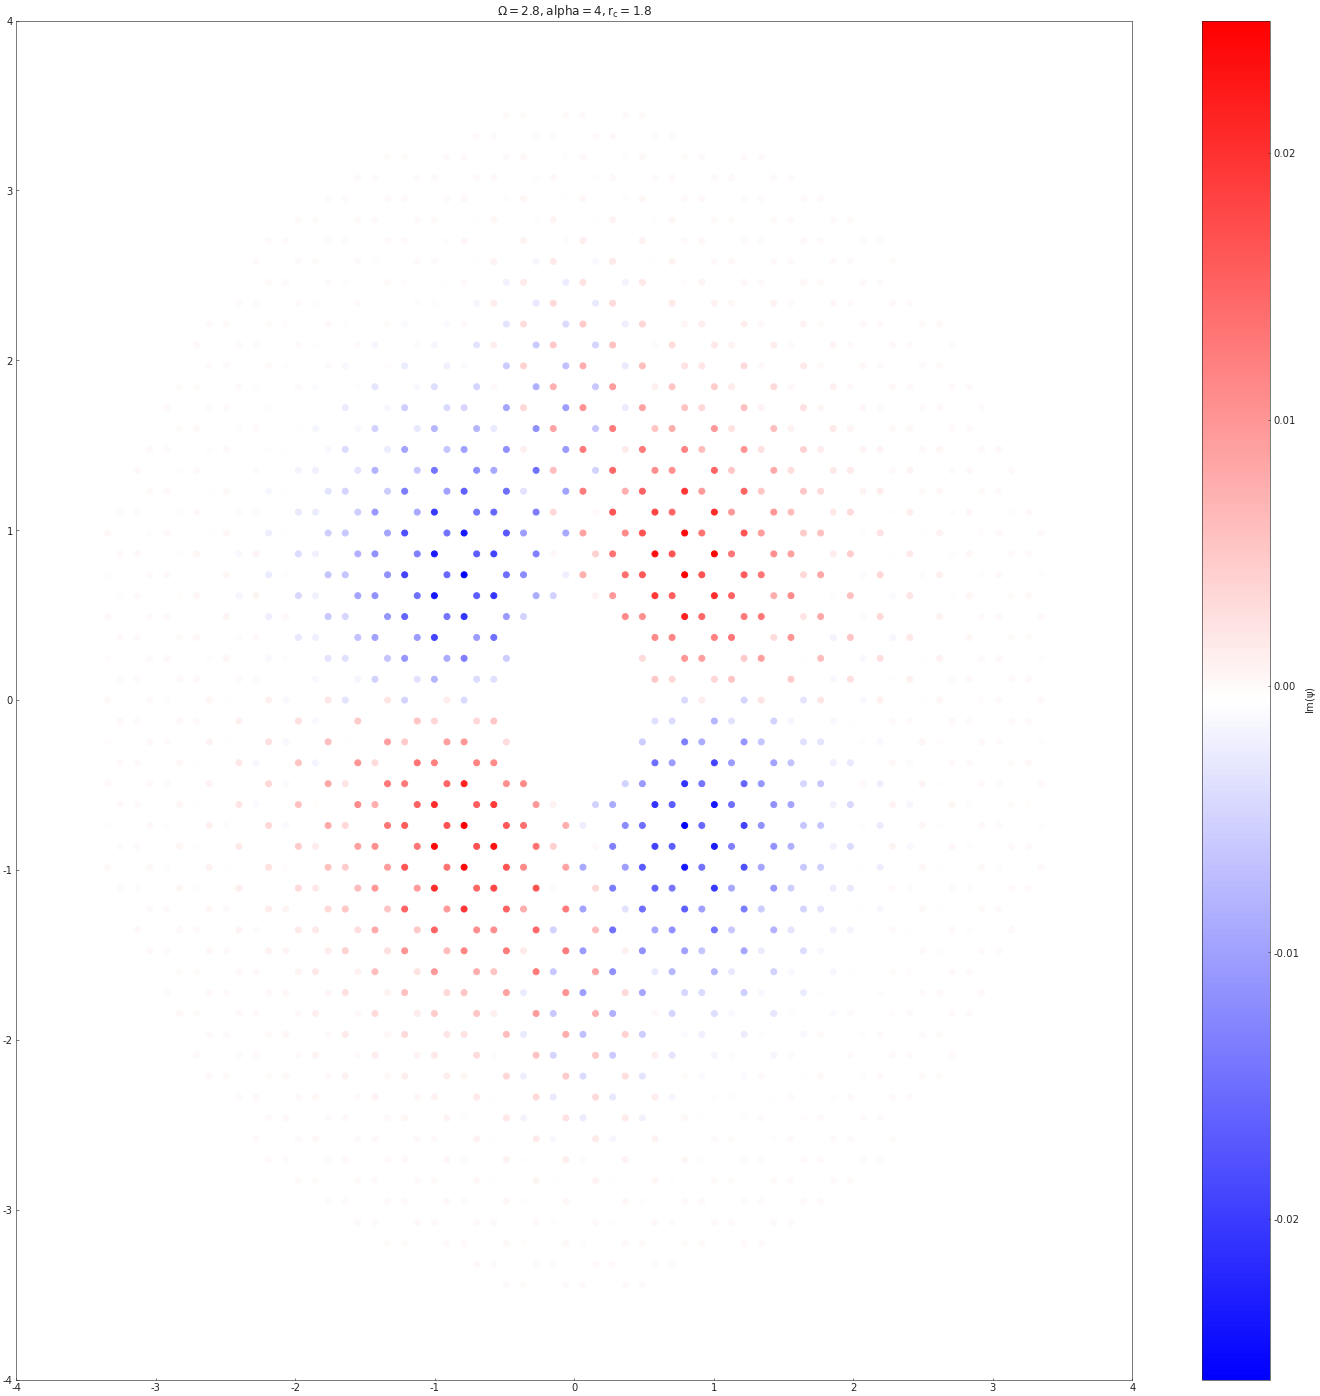

In [102]:
ax = plt.subplot()
plt.figure(figsize=(25,25))
plt.scatter(x_lst,y_lst,c=np.imag(bulk_BS[0]),cmap='bwr')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$Im(\psi)$')
plt.show

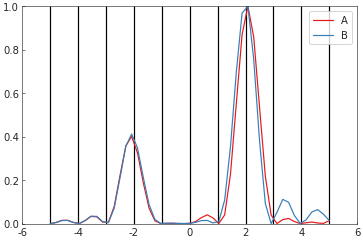

In [22]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

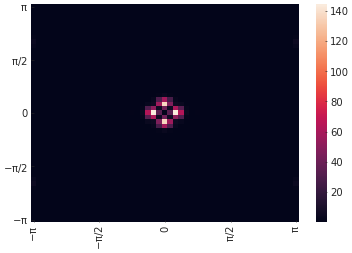

In [81]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

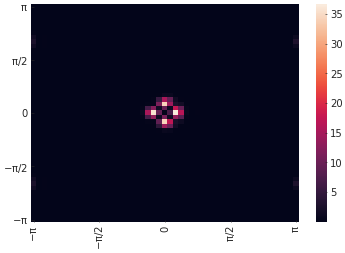

In [82]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

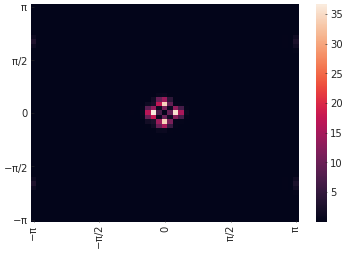

In [83]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

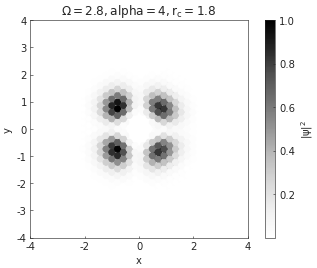

In [16]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[2],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

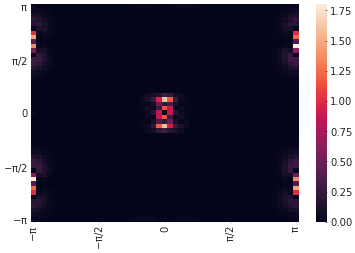

In [94]:
ax = sb.heatmap(np.array(prob_den[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

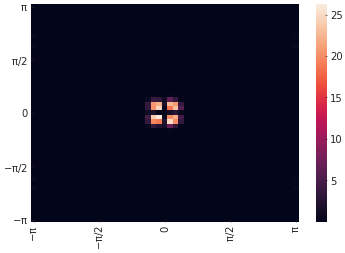

In [95]:
ax = sb.heatmap(np.array(prob_density_A[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

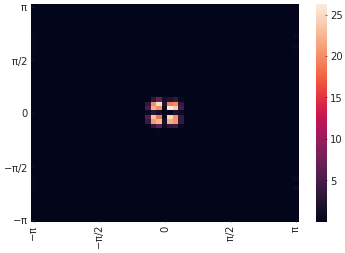

In [96]:
ax = sb.heatmap(np.array(prob_density_B[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

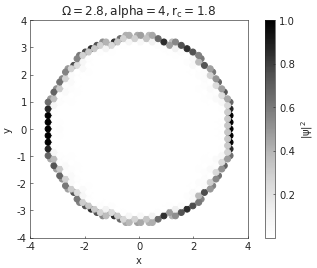

In [17]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[4],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

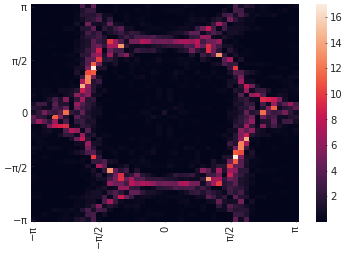

In [97]:
ax = sb.heatmap(np.array(prob_den[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

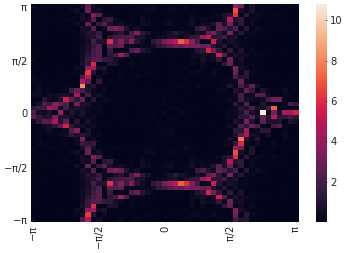

In [98]:
ax = sb.heatmap(np.array(prob_density_A[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

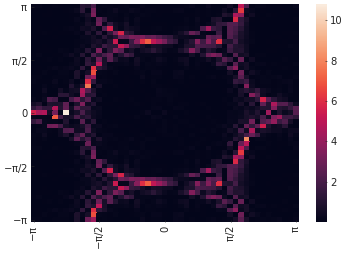

In [99]:
ax = sb.heatmap(np.array(prob_density_B[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

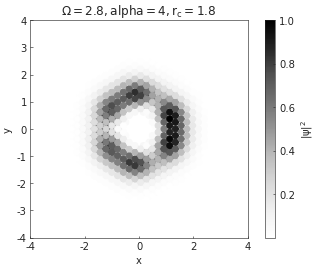

In [18]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[6],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

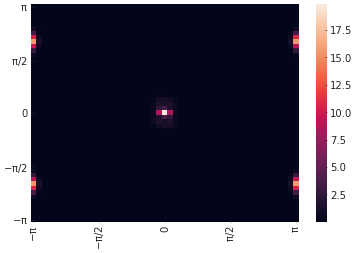

In [100]:
ax = sb.heatmap(np.array(prob_den[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

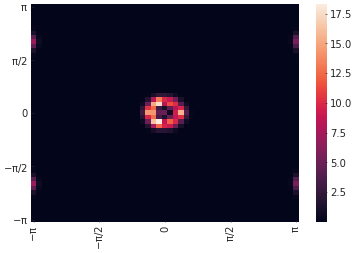

In [101]:
ax = sb.heatmap(np.array(prob_density_A[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

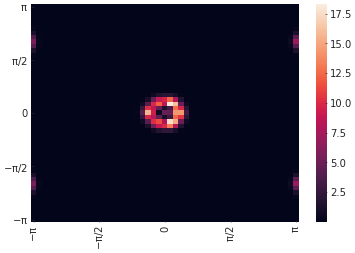

In [102]:
ax = sb.heatmap(np.array(prob_density_B[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

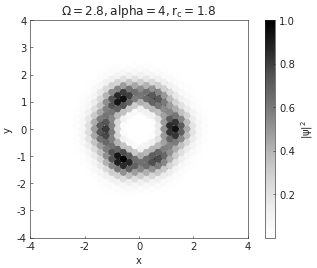

In [19]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[9],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

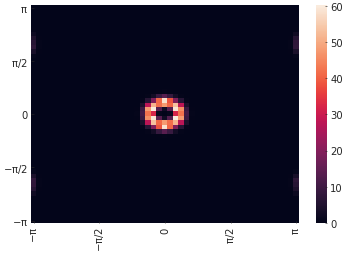

In [106]:
ax = sb.heatmap(np.array(prob_den[9]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

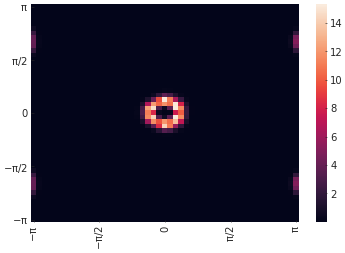

In [108]:
ax = sb.heatmap(np.array(prob_density_A[9]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

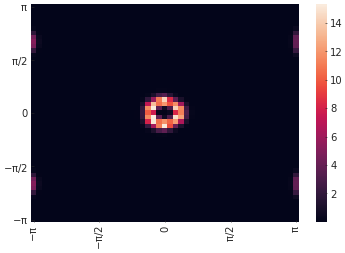

In [109]:
ax = sb.heatmap(np.array(prob_density_B[9]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $\Gamma$-point BS at $\epsilon=0$; $\Omega=2.8, \alpha=4, r_c=1.8, m=-1$ with annular geometry

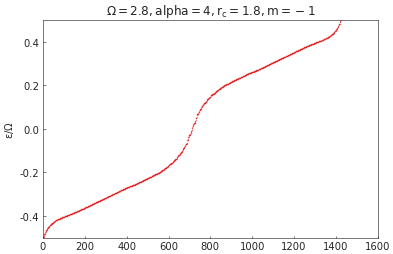

In [16]:
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8, m=-1$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(np.real(quasi_energies))/Omega,s=0.05)

<function matplotlib.pyplot.show(close=None, block=None)>

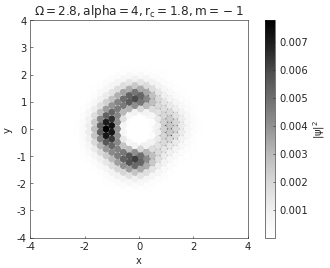

In [23]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=2.8, alpha = 4, r_c = 1.8, m=-1$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

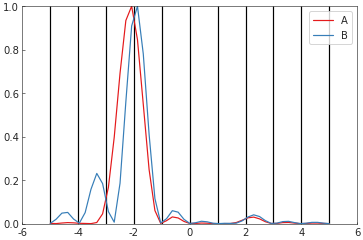

In [31]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

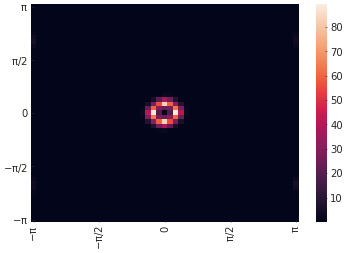

In [24]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

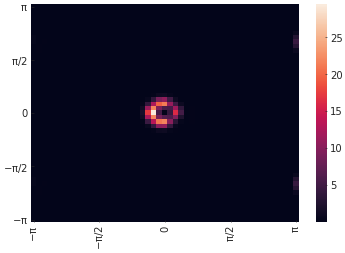

In [31]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

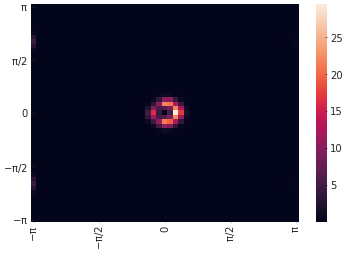

In [25]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $\Gamma$-point BS at $\epsilon=\Omega/2$; $\Omega=5.8, \alpha=3, r_c=1.8$ with annular geometry

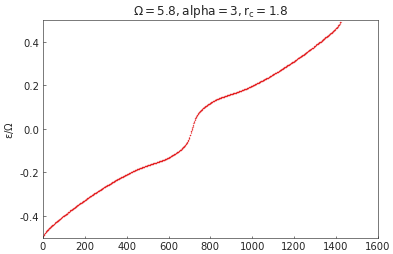

In [117]:
plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(np.real(quasi_energies))/Omega,s=0.05)

<function matplotlib.pyplot.show(close=None, block=None)>

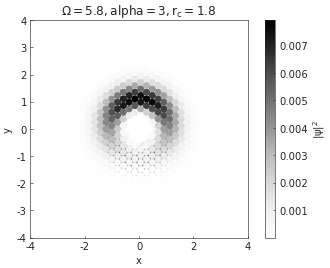

In [84]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

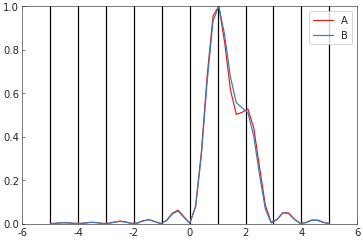

In [40]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

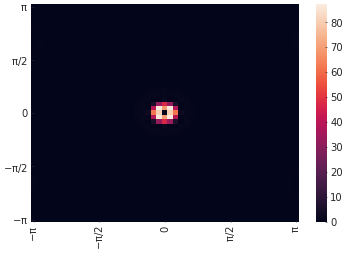

In [121]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

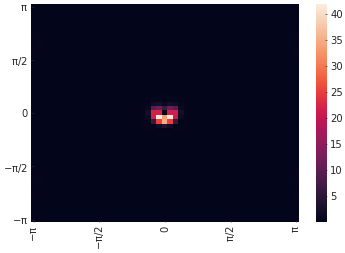

In [134]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

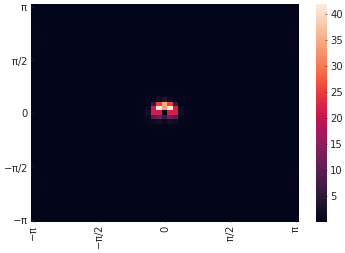

In [123]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

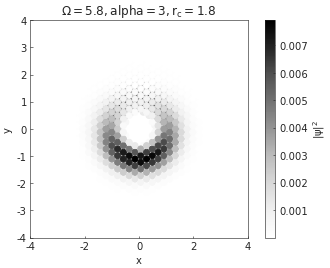

In [85]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[1],cmap='Greys')
plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

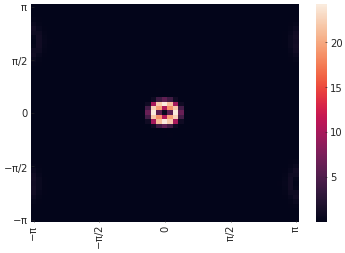

In [125]:
ax = sb.heatmap(np.array(prob_den[1]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

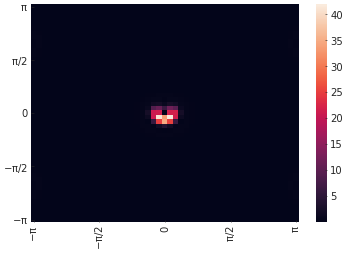

In [126]:
ax = sb.heatmap(np.array(prob_density_A[1]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

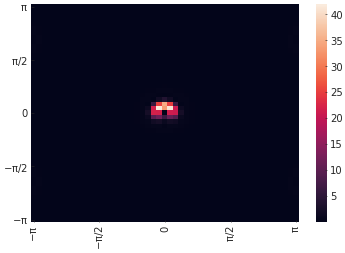

In [127]:
ax = sb.heatmap(np.array(prob_density_B[1]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $\Gamma$-point BS at $\epsilon=\Omega/2$; $\Omega=5.8, \alpha=3, r_c=1.8$ with disk geometry

In [22]:
theta = np.linspace(0,2*np.pi,100)
radius = 1.76
x = radius * np.cos( theta )
y = radius * np.sin( theta )

In [23]:
shape = ring(inner_radius=0, outer_radius=3)

In [24]:
point1 = [0, 5.4*np.pi]
point2 = [4.7*np.pi, 2.7*np.pi]
x_values1 = [point1[0], point2[0]]
y_values1 = [point1[1], point2[1]]
x_values2 = [point2[0], point2[0]]
y_values2 = [point2[1], -point2[1]]
x_values3 = [point2[0], point1[0]]
y_values3 = [-point2[1], -point1[1]]
x_values4 = [point1[0], -point2[0]]
y_values4 = [-point1[1], -point2[1]]
x_values5 = [-point2[0], -point2[0]]
y_values5 = [-point2[1], point2[1]]
x_values6 = [-point2[0], point1[0]]
y_values6 = [point2[1], point1[1]]

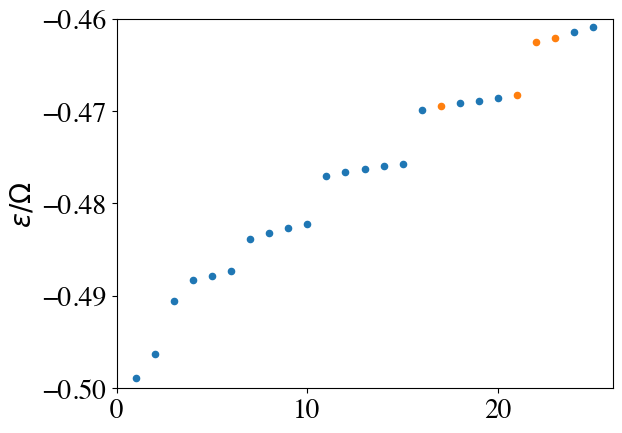

In [274]:
plt.ylabel(r'$\epsilon/\Omega$')
plt.xlim(0,26)
plt.ylim([-0.5,-0.46])
plt.scatter(np.linspace(1,k,k),np.append(-np.array(bulk_eval[:k:2]),np.flip(np.array(bulk_eval[:k:2])))/Omega,s=20)
plt.scatter(np.linspace(1,k,k),np.append(-np.array(edge_eval[:k:2]),np.flip(np.array(edge_eval[:k:2])))/Omega,s=20)
plt.show()

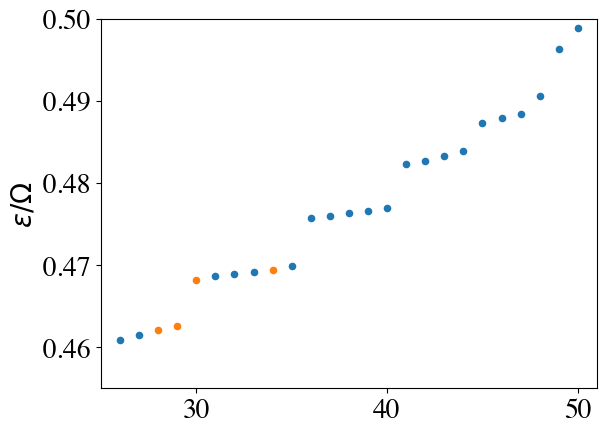

In [275]:
plt.ylabel(r'$\epsilon/\Omega$')
plt.xlim(25,51)
plt.ylim([0.455,0.5])
plt.scatter(np.linspace(1,k,k),np.append(-np.array(bulk_eval[:k:2]),np.flip(np.array(bulk_eval[:k:2])))/Omega,s=20)
plt.scatter(np.linspace(1,k,k),np.append(-np.array(edge_eval[:k:2]),np.flip(np.array(edge_eval[:k:2])))/Omega,s=20)
plt.show()

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


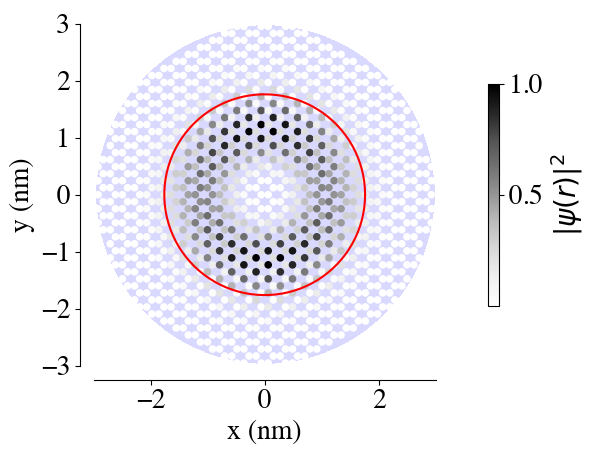

In [45]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[4],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


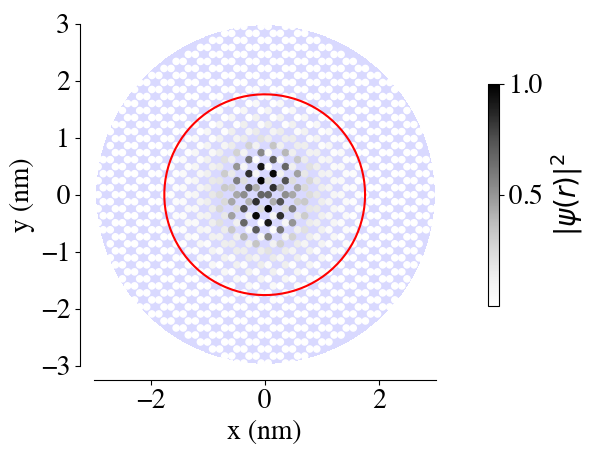

In [47]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[0],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


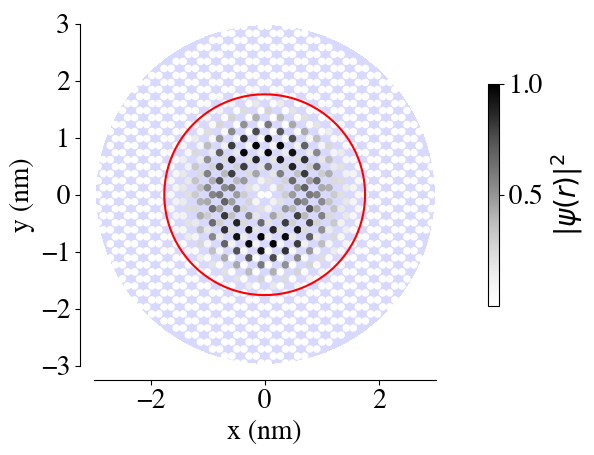

In [30]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[2],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


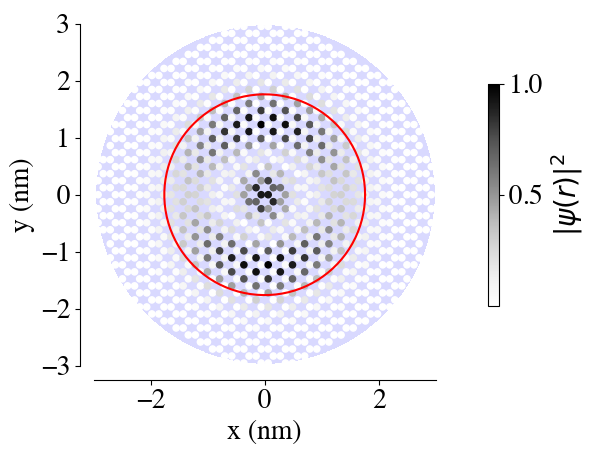

In [35]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[6],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


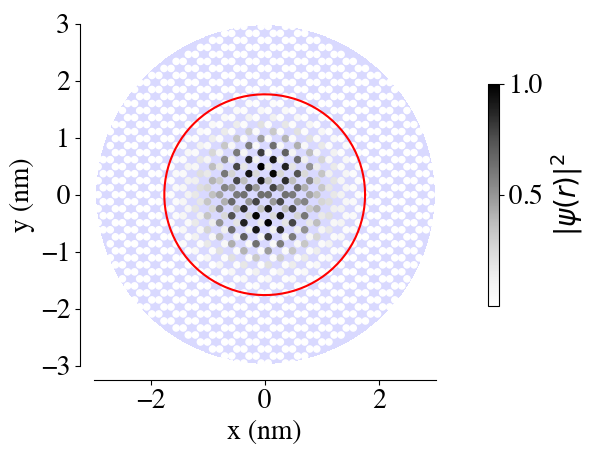

In [37]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[8],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


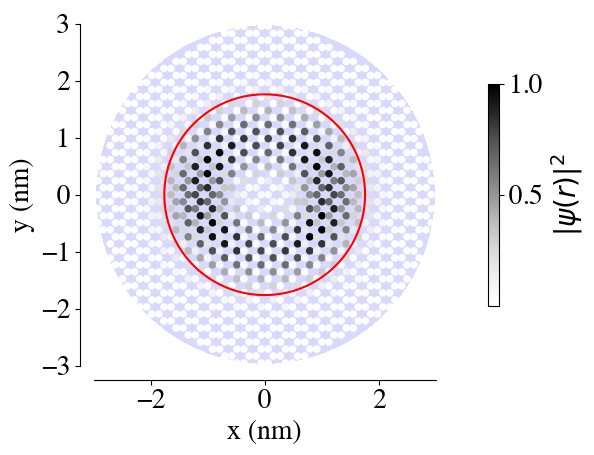

In [38]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[10],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


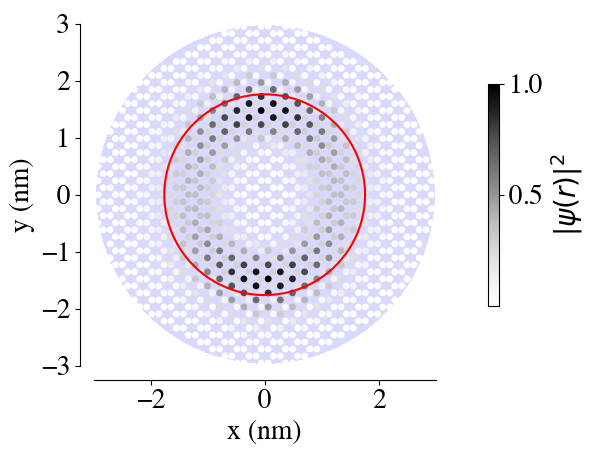

In [87]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[12],cmap='Greys',s=15)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


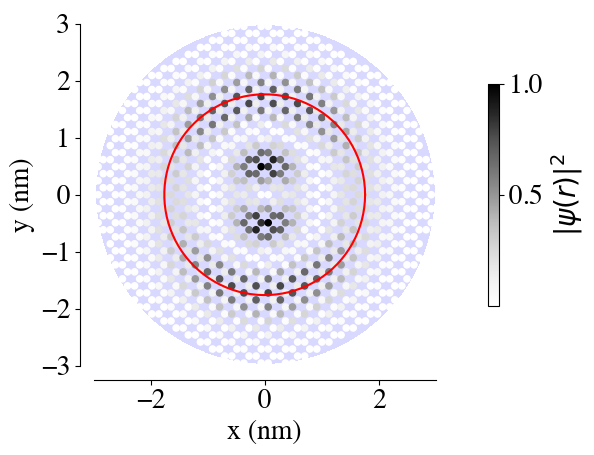

In [39]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[14],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


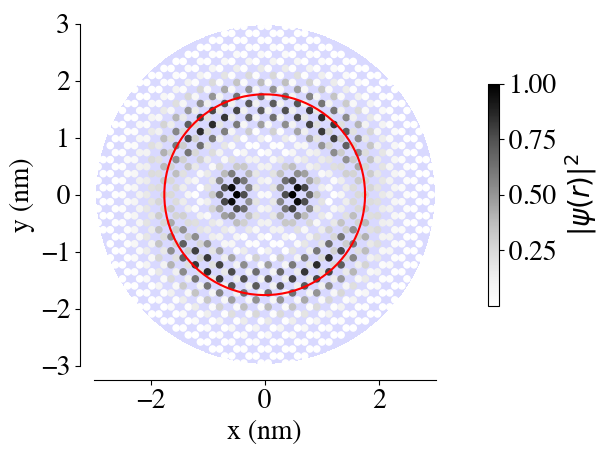

In [42]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[16],cmap='Greys',s=20)
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

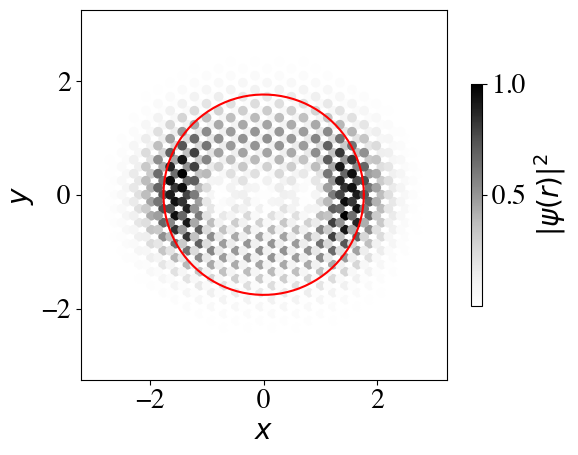

In [30]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[18],cmap='Greys')
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

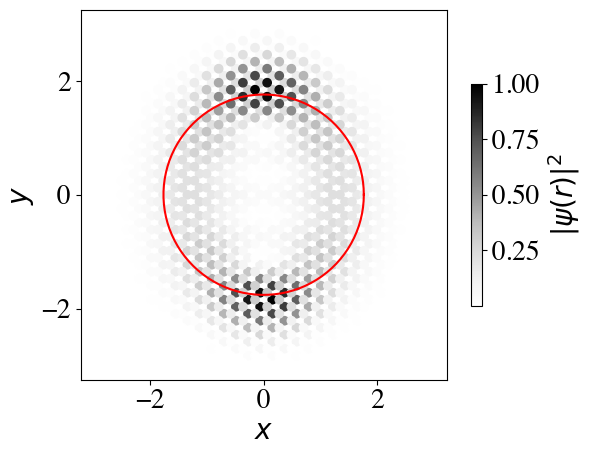

In [19]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[20],cmap='Greys')
plt.plot(x,y,color='red')
#plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

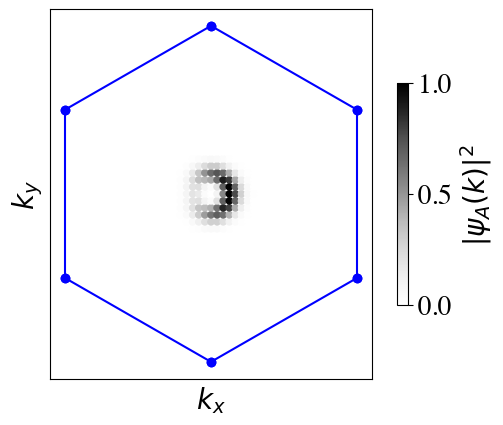

In [88]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_A[4],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_A(k)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

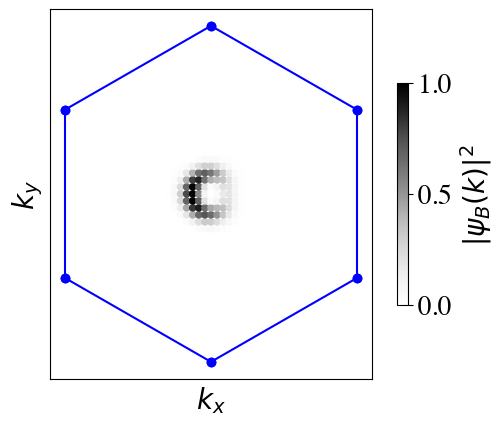

In [43]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_B[4],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_B(k)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

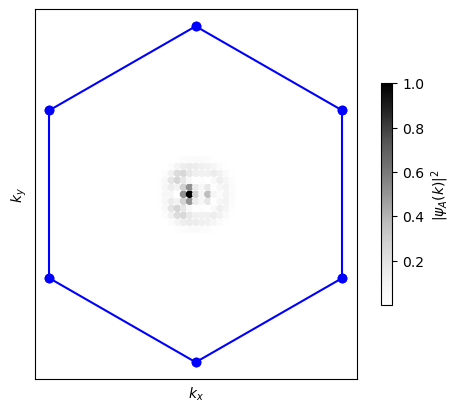

In [148]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_A[16],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_A(k)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

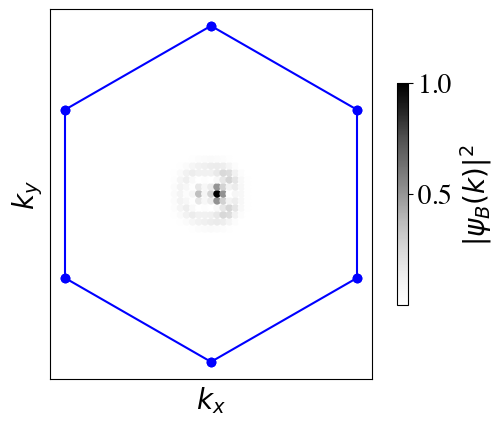

In [64]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_B[16],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_B(k)|^2$')
plt.show

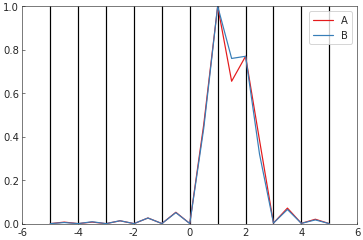

In [308]:
plt.plot(ang_mom,prob_den_m_A[2],label='A')
plt.plot(ang_mom,prob_den_m_B[2],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

# $\Gamma$-point BS at $\epsilon=\Omega/2$; $\Omega=5.8, \alpha=3, r_c=1.8, m=-1$ with annular geometry

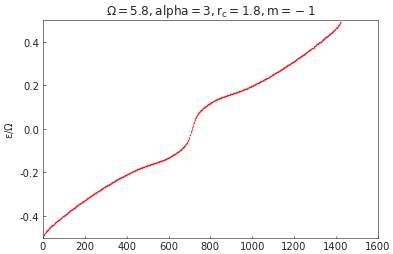

In [42]:
plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8, m=-1$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(np.real(quasi_energies))/Omega,s=0.05)

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

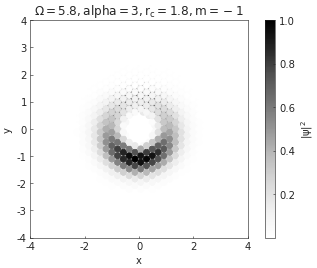

In [162]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8, m=-1$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

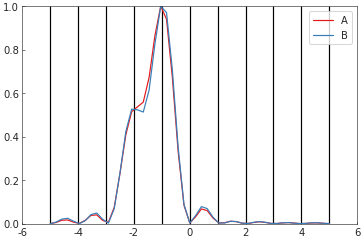

In [49]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

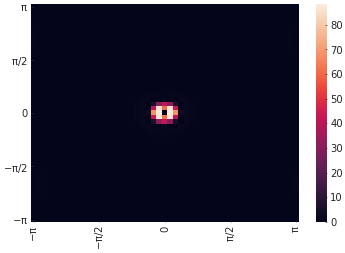

In [44]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

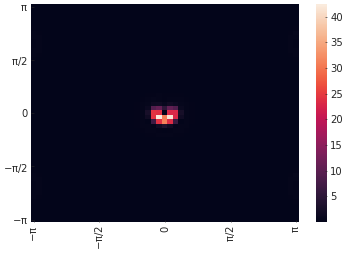

In [45]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

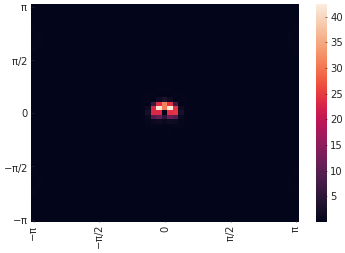

In [46]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $\Gamma$-point BS at $\epsilon=\Omega/2$; $\Omega=5.8, \alpha=3, r_c=1.8, m=-1$ with disk geometry

<function matplotlib.pyplot.show(close=None, block=None)>

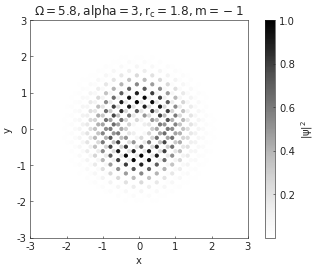

In [322]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[2],cmap='Greys',s=10)
plt.title('$\Omega=5.8, alpha = 3, r_c = 1.8, m=-1$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar()
cbar.set_label('$|\psi|^2$')
plt.show

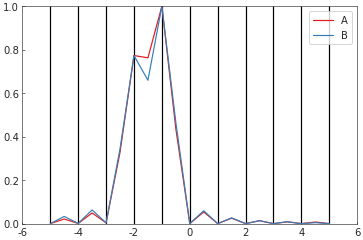

In [324]:
plt.plot(ang_mom,prob_den_m_A[2],label='A')
plt.plot(ang_mom,prob_den_m_B[2],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

# $K$-point BS at $\epsilon=\Omega/2$; $\Omega=1, \alpha=4, r_c=2.3$ with annular geometry

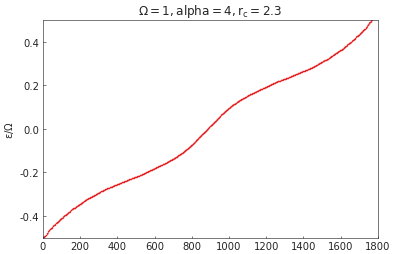

In [142]:
plt.title('$\Omega=1, alpha = 4, r_c = 2.3$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(quasi_energies)/Omega,s=0.05)

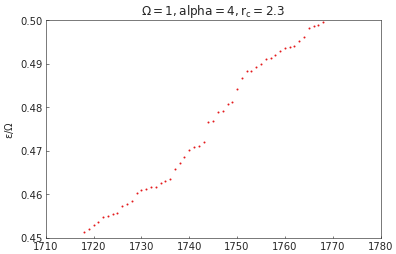

In [147]:
plt.title('$\Omega=1, alpha = 4, r_c = 2.3$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(0.45,0.5)
plt.xlim(1710,1780)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(quasi_energies)/Omega,s=1)

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

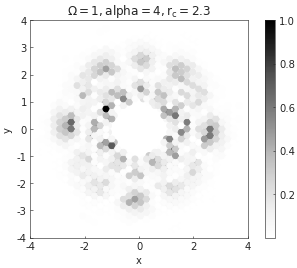

In [172]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=1, alpha = 4, r_c = 2.3$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

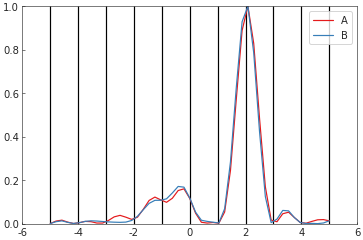

In [58]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

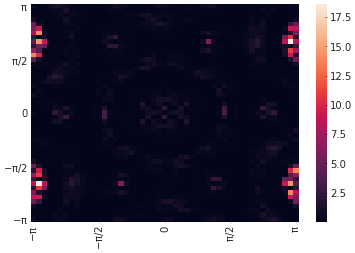

In [161]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

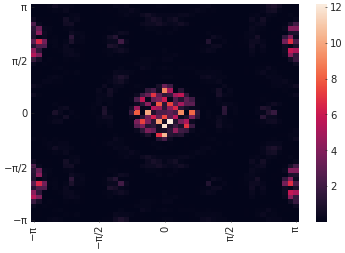

In [162]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

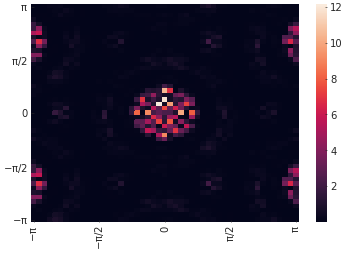

In [163]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

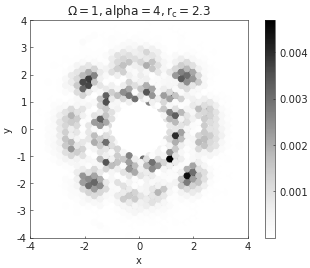

In [98]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[2],cmap='Greys')
plt.title('$\Omega=1, alpha = 4, r_c = 2.3$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

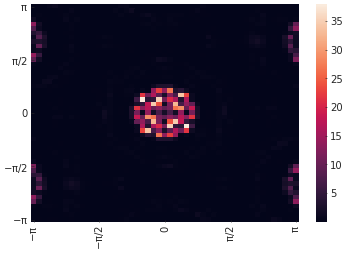

In [164]:
ax = sb.heatmap(np.array(prob_den[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

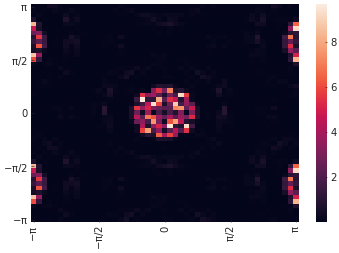

In [165]:
ax = sb.heatmap(np.array(prob_density_A[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

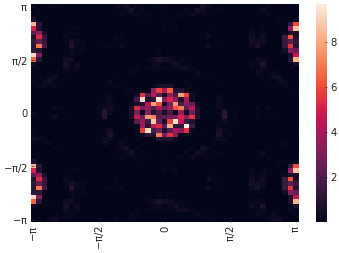

In [166]:
ax = sb.heatmap(np.array(prob_density_B[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

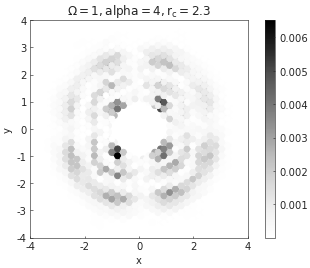

In [99]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[4],cmap='Greys')
plt.title('$\Omega=1, alpha = 4, r_c = 2.3$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

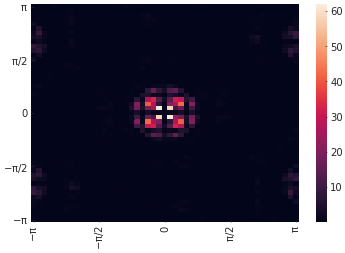

In [171]:
ax = sb.heatmap(np.array(prob_den[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

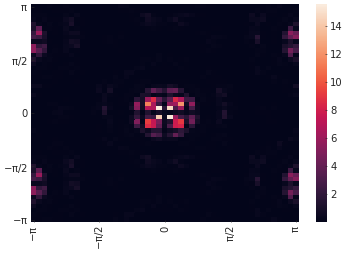

In [168]:
ax = sb.heatmap(np.array(prob_density_A[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

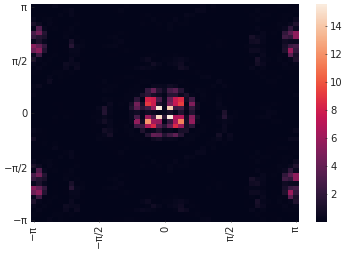

In [169]:
ax = sb.heatmap(np.array(prob_density_B[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

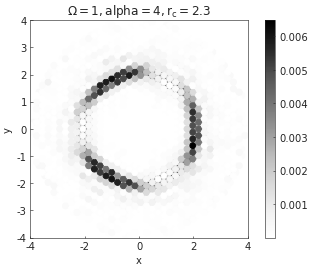

In [100]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[6],cmap='Greys')
plt.title('$\Omega=1, alpha = 4, r_c = 2.3$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

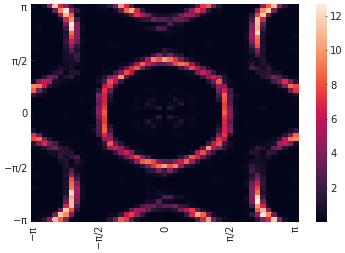

In [172]:
ax = sb.heatmap(np.array(prob_den[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

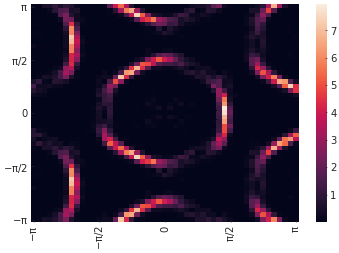

In [173]:
ax = sb.heatmap(np.array(prob_density_A[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

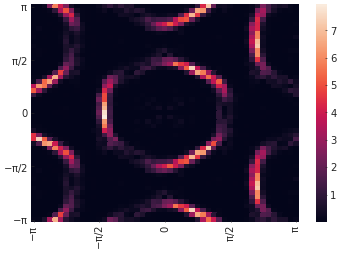

In [174]:
ax = sb.heatmap(np.array(prob_density_B[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

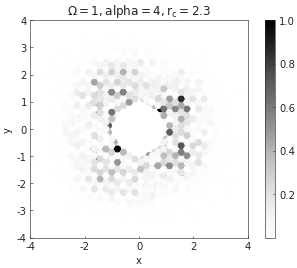

In [207]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[8],cmap='Greys')
plt.title('$\Omega=1, alpha = 4, r_c = 2.3$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

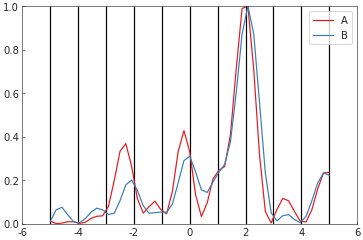

In [59]:
plt.plot(ang_mom,prob_den_m_A[8],label='A')
plt.plot(ang_mom,prob_den_m_B[8],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

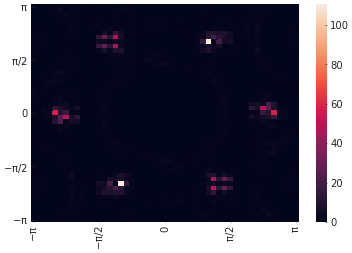

In [175]:
ax = sb.heatmap(np.array(prob_den[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

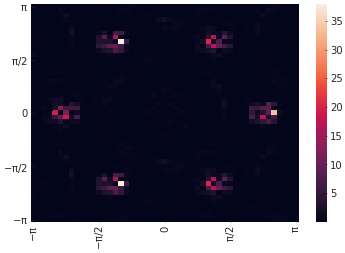

In [176]:
ax = sb.heatmap(np.array(prob_density_A[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

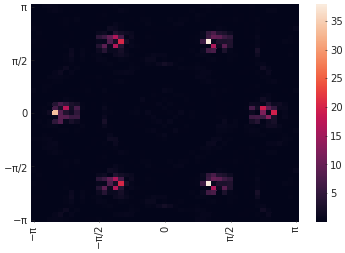

In [177]:
ax = sb.heatmap(np.array(prob_density_B[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

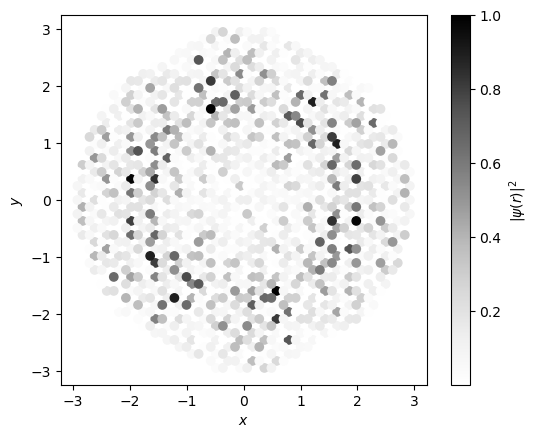

In [133]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[14],cmap='Greys')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar()
cbar.set_label(r'$|\psi(r)|^2$')
plt.show

# $K$-point BS at $\epsilon=\Omega/2$; $\Omega=1, \alpha=3.2, r_c=2.8$ with disk geometry

<function matplotlib.pyplot.show(close=None, block=None)>

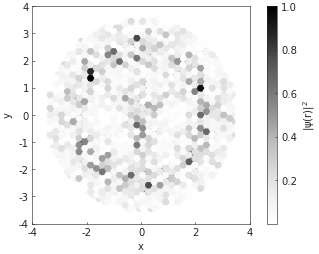

In [31]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[6],cmap='Greys')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar()
cbar.set_label(r'$|\psi(r)|^2$')
plt.show

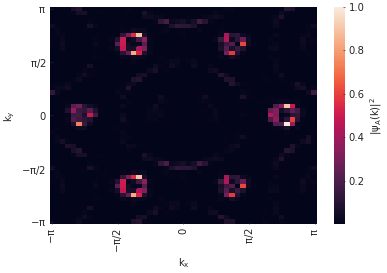

In [30]:
ax = sb.heatmap(np.array(prob_density_A[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky,cbar_kws={'label': r'$|\psi_A(k)|^2$'})
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels([r'$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels([r'$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

In [ ]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky,cbar_kws={'label': r'$|\psi_B(k)|^2$'})
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels([r'$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels([r'$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $K$-point BS at $\epsilon=\Omega/2$; $\Omega=1, \alpha=22.3, r_c=2$ with annular geometry

In [ ]:
plt.title('$\Omega=1, alpha=22.3, r_c=2$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(quasi_energies)/Omega,s=0.05)

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

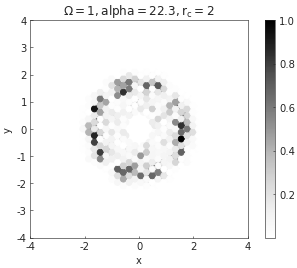

In [182]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

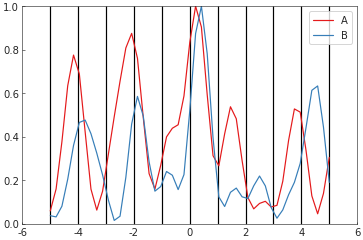

In [68]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

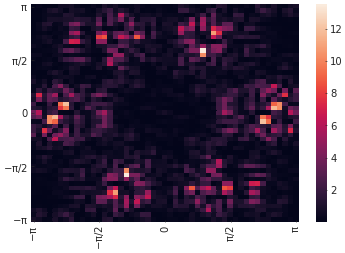

In [18]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

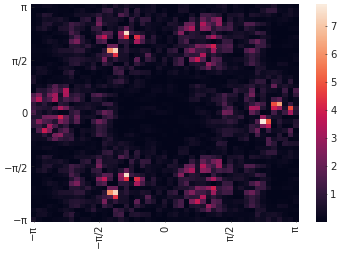

In [19]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

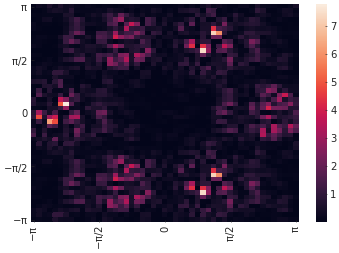

In [20]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

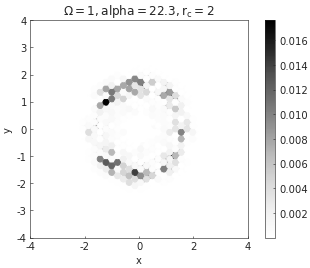

In [109]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[2],cmap='Greys')
plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

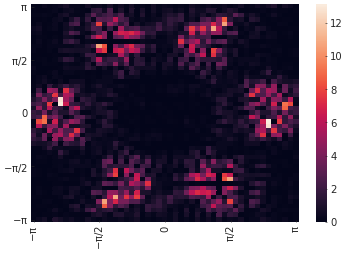

In [20]:
ax = sb.heatmap(np.array(prob_den[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

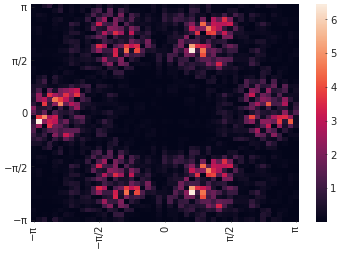

In [41]:
ax = sb.heatmap(np.array(prob_density_A[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

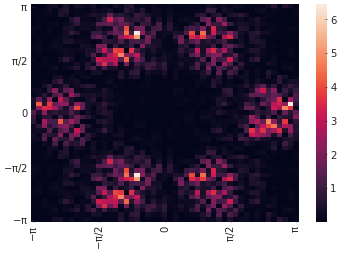

In [42]:
ax = sb.heatmap(np.array(prob_density_B[2]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

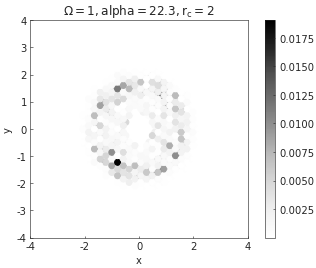

In [110]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[4],cmap='Greys')
plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

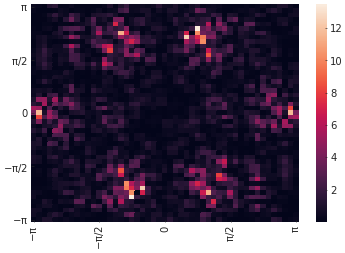

In [43]:
ax = sb.heatmap(np.array(prob_den[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

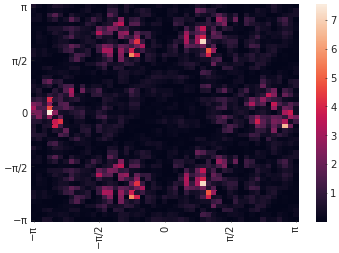

In [44]:
ax = sb.heatmap(np.array(prob_density_A[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

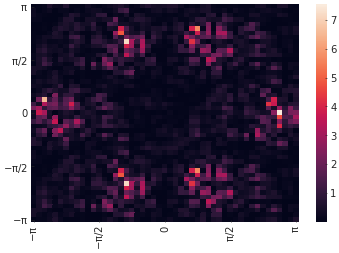

In [45]:
ax = sb.heatmap(np.array(prob_density_B[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

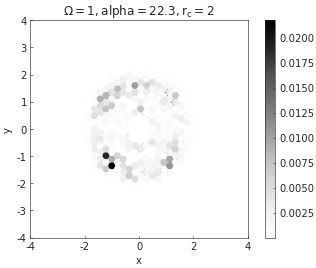

In [111]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[6],cmap='Greys')
plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

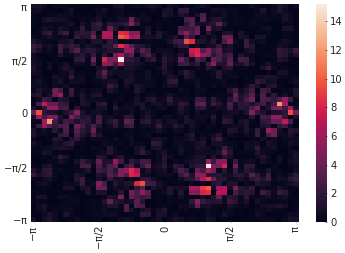

In [47]:
ax = sb.heatmap(np.array(prob_den[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

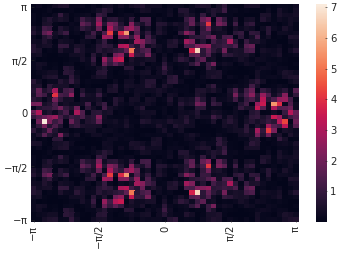

In [48]:
ax = sb.heatmap(np.array(prob_density_A[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

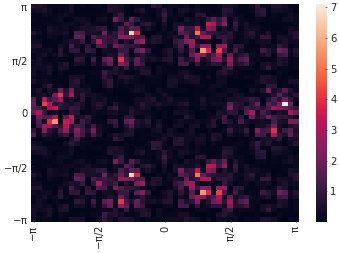

In [46]:
ax = sb.heatmap(np.array(prob_density_B[6]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

<function matplotlib.pyplot.show(close=None, block=None)>

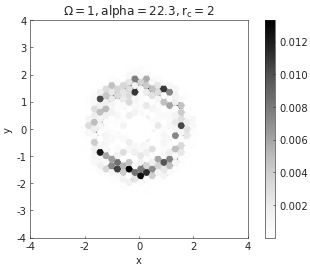

In [112]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[8],cmap='Greys')
plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

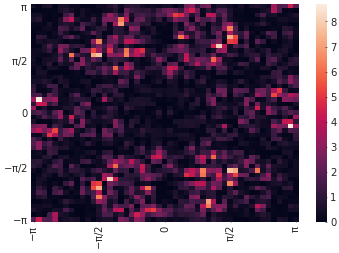

In [54]:
ax = sb.heatmap(np.array(prob_den[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

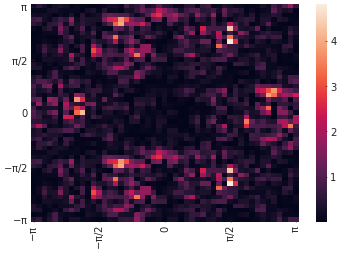

In [55]:
ax = sb.heatmap(np.array(prob_density_A[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

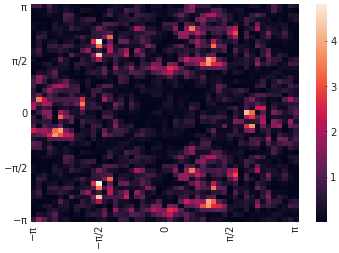

In [56]:
ax = sb.heatmap(np.array(prob_density_B[8]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $K$-point BS at $\epsilon=\Omega/2$; $\Omega=1, \alpha=22.3, r_c=2$ with disk geometry

In [98]:
theta = np.linspace(0,2*np.pi,100)
radius = 2.04
x = radius * np.cos( theta )
y = radius * np.sin( theta )

In [99]:
shape = ring(inner_radius=0, outer_radius=3)

In [100]:
point1 = [0, 5.4*np.pi]
point2 = [4.7*np.pi, 2.7*np.pi]
x_values1 = [point1[0], point2[0]]
y_values1 = [point1[1], point2[1]]
x_values2 = [point2[0], point2[0]]
y_values2 = [point2[1], -point2[1]]
x_values3 = [point2[0], point1[0]]
y_values3 = [-point2[1], -point1[1]]
x_values4 = [point1[0], -point2[0]]
y_values4 = [-point1[1], -point2[1]]
x_values5 = [-point2[0], -point2[0]]
y_values5 = [-point2[1], point2[1]]
x_values6 = [-point2[0], point1[0]]
y_values6 = [point2[1], point1[1]]

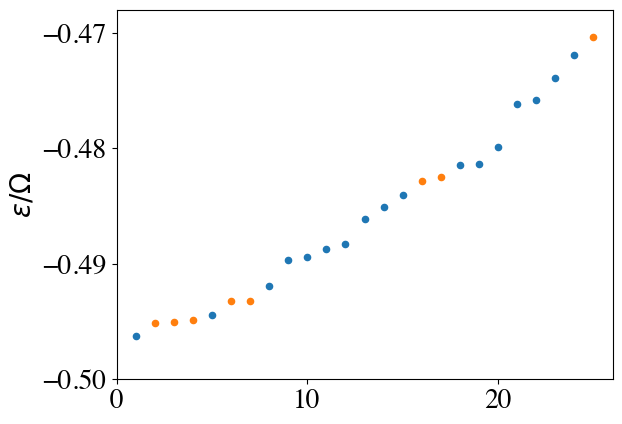

In [33]:
bulk_eval = np.where(np.array(bulk_eval)==0, np.nan, bulk_eval)
edge_eval = np.where(np.array(edge_eval)==0, np.nan, edge_eval)
plt.ylabel(r'$\epsilon/\Omega$')
plt.xlim(0,26)
plt.ylim(-0.5,-0.468)
plt.scatter(np.linspace(1,k,k),np.append(-np.array(bulk_eval[:k:2]),np.flip(np.array(bulk_eval[:k:2])))/Omega,s=20)
plt.scatter(np.linspace(1,k,k),np.append(-np.array(edge_eval[:k:2]),np.flip(np.array(edge_eval[:k:2])))/Omega,s=20)
plt.show()

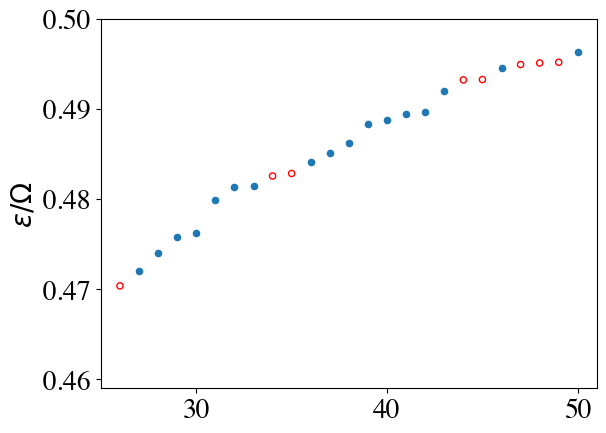

In [35]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.style'] = 'normal'
plt.ylabel(r'$\epsilon/\Omega$')
plt.xlim(25,51)
plt.ylim([0.459,0.5])
plt.scatter(np.linspace(1,k,k),np.append(-np.array(bulk_eval[:k:2]),np.flip(np.array(bulk_eval[:k:2])))/Omega,s=20)
plt.scatter(np.linspace(1,k,k),np.append(-np.array(edge_eval[:k:2]),np.flip(np.array(edge_eval[:k:2])))/Omega,s=20,facecolor="none",edgecolors="r")
plt.show()

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


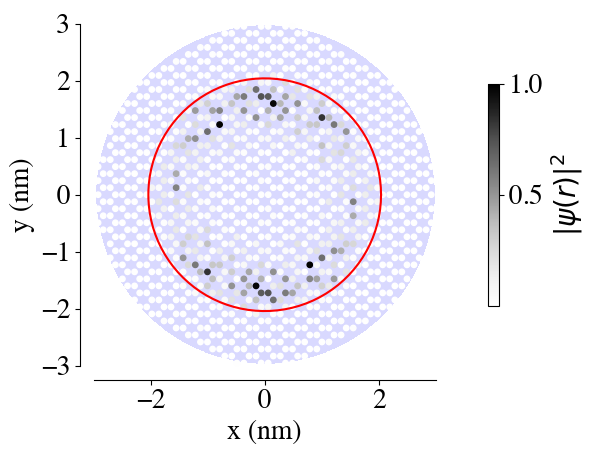

In [67]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[0],cmap='Greys',s=15)
plt.plot(x,y,color='red')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


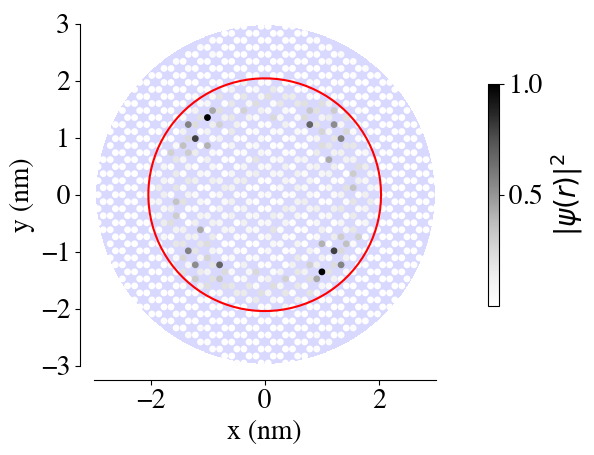

In [68]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[2],cmap='Greys',s=15)
plt.plot(x,y,color='red')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


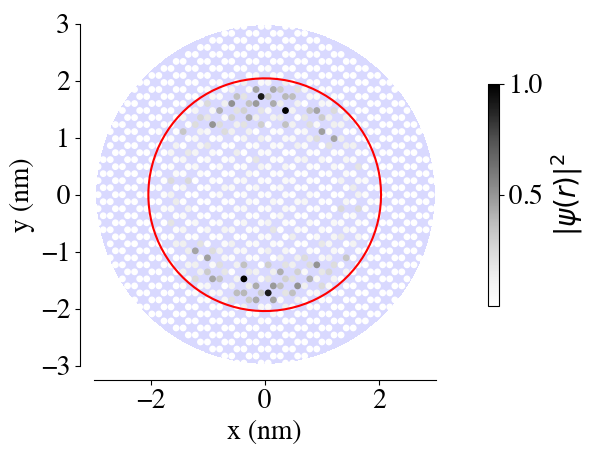

In [69]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[4],cmap='Greys',s=15)
plt.plot(x,y,color='red')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


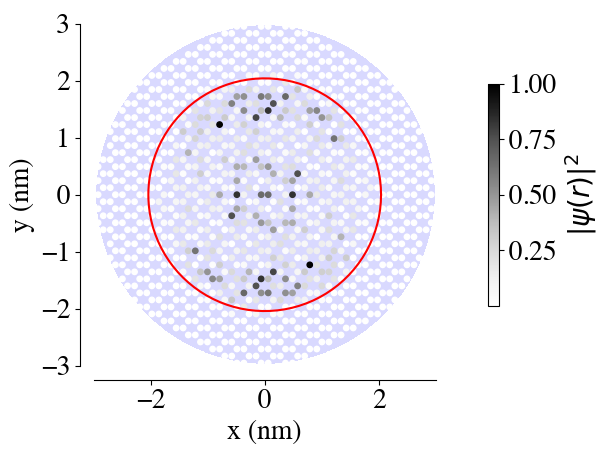

In [76]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[6],cmap='Greys',s=15)
plt.plot(x,y,color='red')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


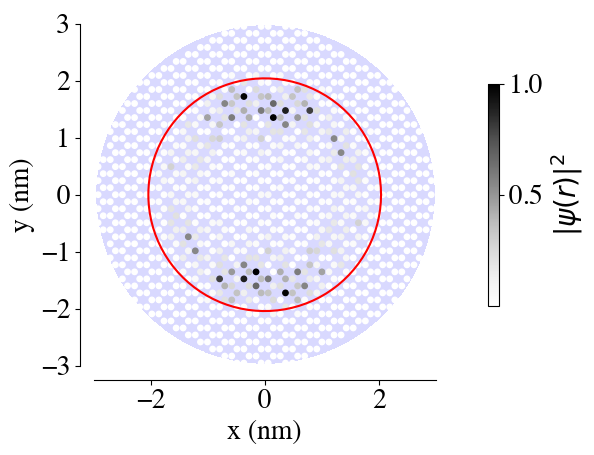

In [77]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[8],cmap='Greys',s=15)
plt.plot(x,y,color='red')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:449: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


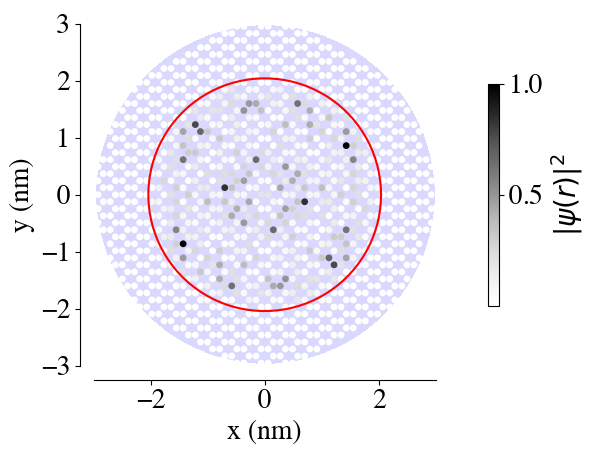

In [81]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[16],cmap='Greys',s=15)
plt.plot(x,y,color='red')
#plt.title('$\Omega=1, alpha=22.3, r_c = 2$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi(r)|^2$')
shape.plot(color='blue')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

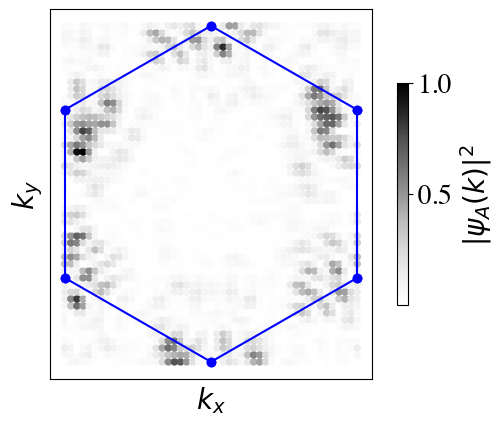

In [74]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_A[0],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_A(k)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

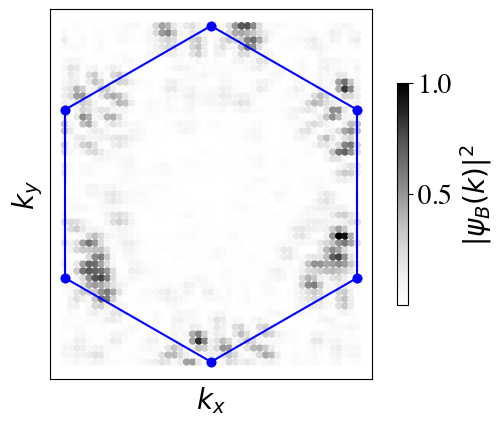

In [53]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_B[0],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_B(k)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

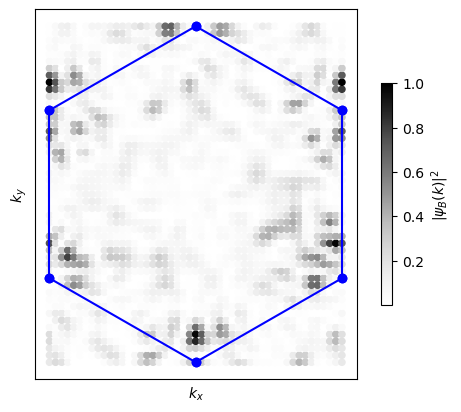

In [122]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_A[16],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_B(k)|^2$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

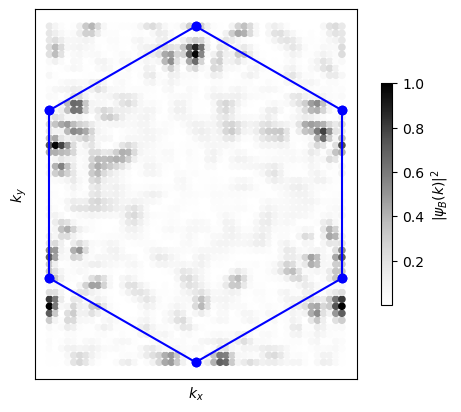

In [130]:
ax = plt.subplot()
plt.scatter(Kx,Ky,c=prob_density_B[16],cmap='Greys',s=20)
plt.plot(x_values1, y_values1, 'bo', linestyle="-")
plt.plot(x_values2, y_values2, 'bo', linestyle="-")
plt.plot(x_values3, y_values3, 'bo', linestyle="-")
plt.plot(x_values4, y_values4, 'bo', linestyle="-")
plt.plot(x_values5, y_values5, 'bo', linestyle="-")
plt.plot(x_values6, y_values6, 'bo', linestyle="-")
ax.set_aspect('equal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
plt.tick_params(left = False, labelleft = False ,
                labelbottom = False, bottom = False)
cbar = plt.colorbar(shrink=0.6)
cbar.set_label(r'$|\psi_B(k)|^2$')
plt.show

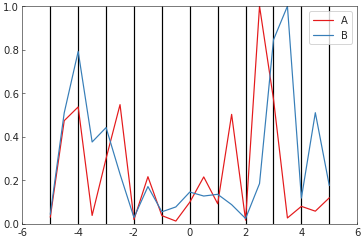

In [342]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

# $K$-point BS at $\epsilon=\Omega/2$; $\Omega=1, \alpha=22.3, r_c=2, m=-1$ with annular geometry

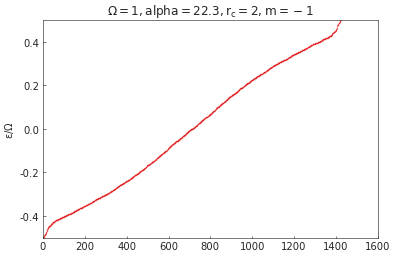

In [56]:
plt.title('$\Omega=1, alpha=22.3, r_c=2, m=-1$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(quasi_energies)/Omega,s=0.05)

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(close=None, block=None)>

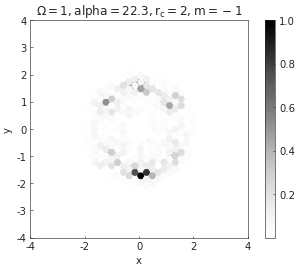

In [194]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=1, alpha=22.3, r_c = 2, m=-1$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

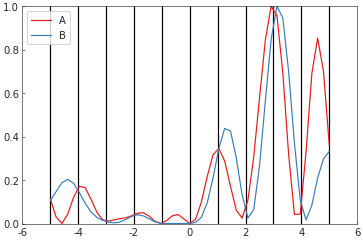

In [77]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

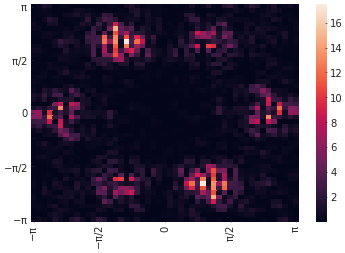

In [58]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

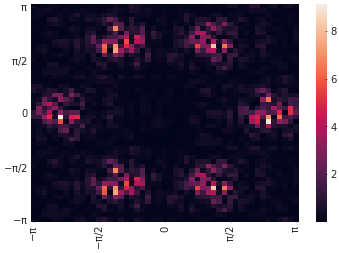

In [59]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

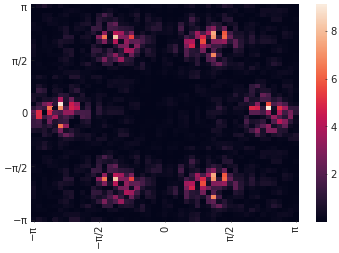

In [60]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# $K$-point BS at $\epsilon=\Omega/2$; $\Omega=1, \alpha=22.3, r_c=2, m=-1$ with disk geometry

<function matplotlib.pyplot.show(close=None, block=None)>

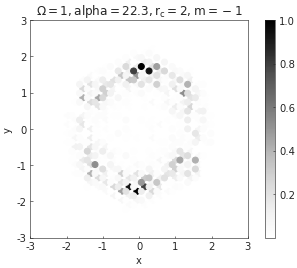

In [358]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[0],cmap='Greys')
plt.title('$\Omega=1, alpha=22.3, r_c = 2, m=-1$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

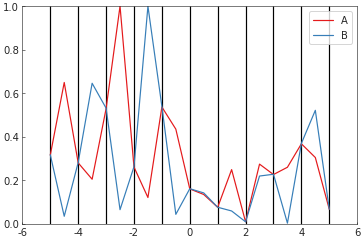

In [359]:
plt.plot(ang_mom,prob_den_m_A[0],label='A')
plt.plot(ang_mom,prob_den_m_B[0],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

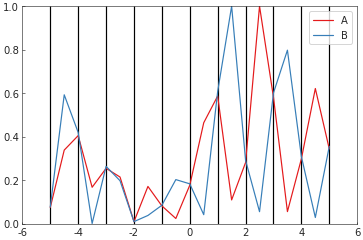

In [360]:
plt.plot(ang_mom,prob_den_m_A[1],label='A')
plt.plot(ang_mom,prob_den_m_B[1],label='B')
plt.vlines([-5,-4,-3,-2,-1,0,1,2,3,4,5],0,1,color='black')
plt.legend()
plt.show()

# Multifold degenerate BS at $\epsilon=\Omega/2$; $\Omega=2.01482, \alpha=20, r_c=1.3$ with annular geometry

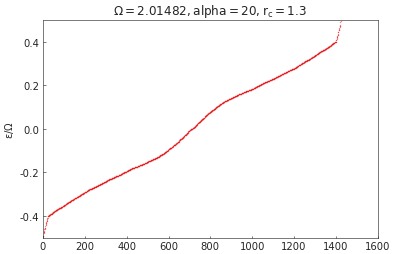

In [185]:
plt.title('$\Omega=2.01482,alpha=20,r_c=1.3$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(quasi_energies)/Omega,s=0.05)

<function matplotlib.pyplot.show(close=None, block=None)>

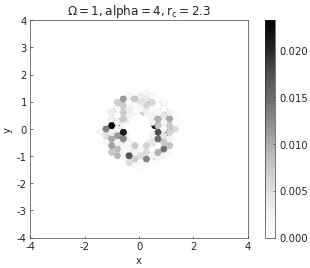

In [119]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=2.01482,alpha=20,r_c=1.3$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

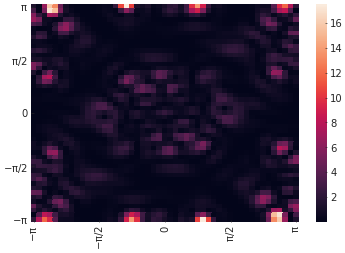

In [202]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

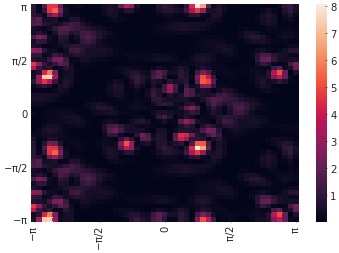

In [203]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

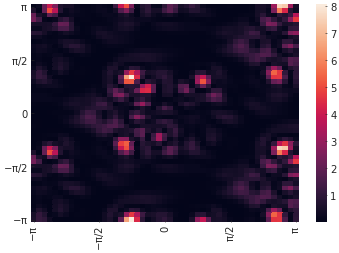

In [204]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# Multifold degenerate BS at $\epsilon=\Omega/2$; $\Omega=2.01482, \alpha=20, r_c=1.3, m=-1$ with annular geometry

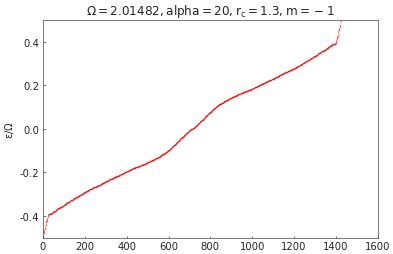

In [70]:
plt.title('$\Omega=2.01482,alpha=20,r_c=1.3, m=-1$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(quasi_energies)/Omega,s=0.05)

<function matplotlib.pyplot.show(close=None, block=None)>

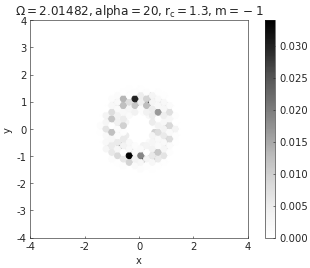

In [71]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=2.01482,alpha=20,r_c=1.3, m=-1$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

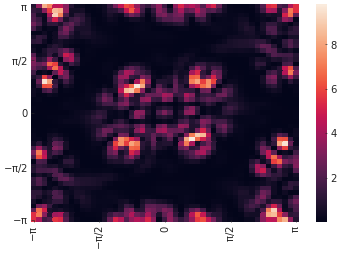

In [72]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

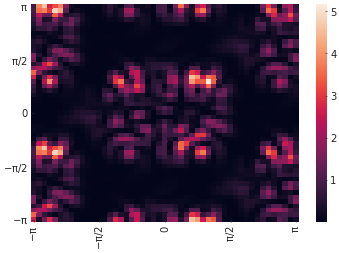

In [73]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

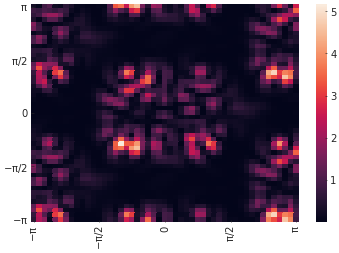

In [74]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# Multifold degenerate BS at $\epsilon=\Omega/2$; $\Omega=2.01482, \alpha=20, r_c=1.3$ with disk geometry

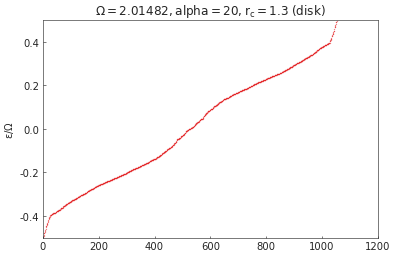

In [212]:
plt.title('$\Omega=2.01482,alpha=20,r_c=1.3\;(disk)$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.scatter(np.linspace(1,np.size(quasi_energies),np.size(quasi_energies)),np.sort(quasi_energies)/Omega,s=0.05)

<function matplotlib.pyplot.show(close=None, block=None)>

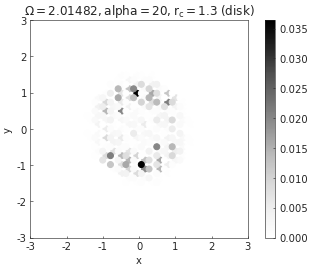

In [126]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_density[0],cmap='Greys')
plt.title('$\Omega=2.01482,alpha=20,r_c=1.3\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.show

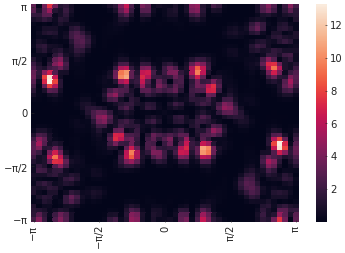

In [228]:
ax = sb.heatmap(np.array(prob_den[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

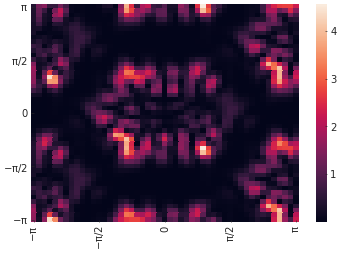

In [229]:
ax = sb.heatmap(np.array(prob_density_A[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

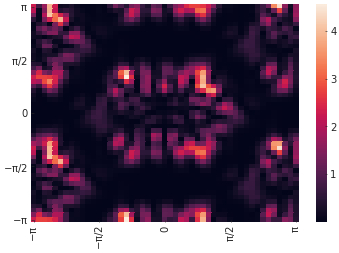

In [230]:
ax = sb.heatmap(np.array(prob_density_B[0]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky)
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels(['$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# Multifold degenerate BS at $\epsilon=\Omega/2$; $\Omega=2.01482, \alpha=9, r_c=2.8$ with disk geometry

<function matplotlib.pyplot.show(close=None, block=None)>

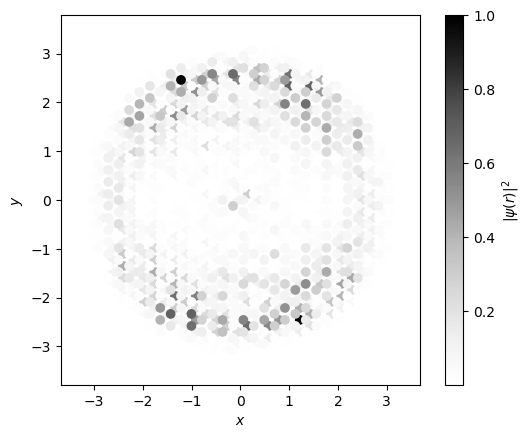

In [39]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[4],cmap='Greys')
#plt.title('$\Omega=2.01482,alpha=20,r_c=1.3\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar()
cbar.set_label(r'$|\psi(r)|^2$')
plt.show

In [15]:
ax = sb.heatmap(np.array(prob_density_A[4]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky,cbar_kws={'label': r'$|\psi_A(k)|^2$'})
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels([r'$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels([r'$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

NameError: name 'prob_density_A' is not defined

# Multifold degenerate BS at $\epsilon=0$; $\Omega=0.7, \alpha=25.6, r_c=3.55, m=2$ with disk geometry

<function matplotlib.pyplot.show(close=None, block=None)>

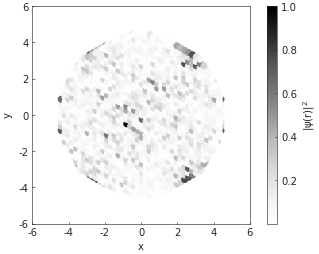

In [19]:
ax = plt.subplot()
plt.scatter(x_lst,y_lst,c=prob_bulk[6],cmap='Greys')
#plt.title('$\Omega=2.01482,alpha=20,r_c=1.3\;(disk)$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar()
cbar.set_label(r'$|\psi(r)|^2$')
plt.show

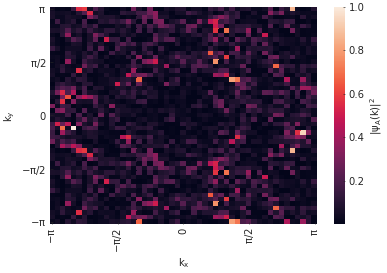

In [28]:
ax = sb.heatmap(np.array(prob_density_A[16]).reshape(Nk,Nk),xticklabels=kx,yticklabels=ky,cbar_kws={'label': r'$|\psi_A(k)|^2$'})
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_xticks(ax.get_xticks()[::int((Nk-1)/4)])
ax.set_xticklabels([r'$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']);
ax.set_yticks(ax.get_yticks()[::int((Nk-1)/4)])
ax.set_yticklabels([r'$\pi$','$\pi/2$','0','$-\pi/2$','$-\pi$']);

# Extras

In [14]:
U = [
    time_evolution(m,Omega,alpha,r[i])
    for i in range(np.size(r))
]
     
#H_F = [
 #   1j*linalg.logm(U[i])*Omega/(2*np.pi)
  #  for i in range(np.size(r))
#]
quasi_energies = [
    np.sort(np.imag(np.log(linalg.eigvals(U[i])))*Omega/(2*np.pi))
    for i in range(np.size(r))
]

In [15]:
quasi_energies_DataFrame = pd.DataFrame(data=quasi_energies)
quasi_energies_DataFrame.to_excel('quasi_energies_O=5.8,a=3.xlsx')

In [16]:
quasi_energies_import = pd.read_excel('quasi_energies_O=5.8,a=3.xlsx').to_numpy()

def qe(j):
    qe_lst = [
        quasi_energies_import[i][j]/Omega
        for i in range(np.size(r))
    ]
    return qe_lst

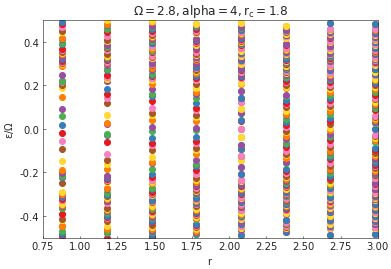

In [10]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.scatter(r,qe(j+1))
plt.title('$\Omega=2.8,alpha = 4, r_c = 1.8$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.show()

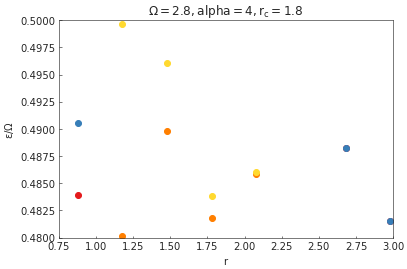

In [11]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.scatter(r,qe(j+1))
plt.title('$\Omega=2.8,alpha = 4, r_c = 1.8$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(0.48,0.5)
plt.show()

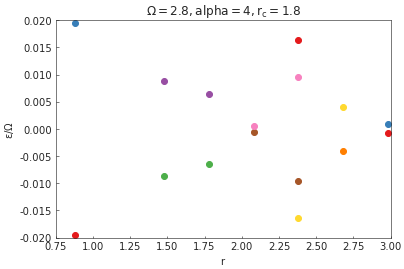

In [12]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.scatter(r,qe(j+1))
plt.title('$\Omega=2.8,alpha = 4, r_c = 1.8$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.02,0.02)
plt.show()

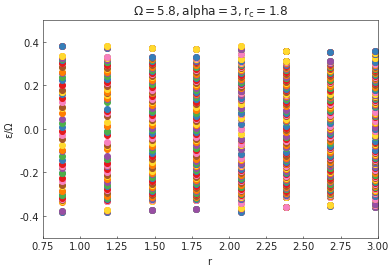

In [17]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.scatter(r,qe(j+1))
plt.title('$\Omega=5.8,alpha = 3, r_c = 1.8$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.5,0.5)
plt.show()

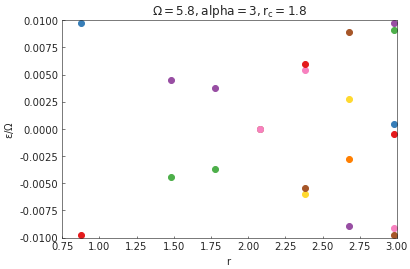

In [18]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.scatter(r,qe(j+1))
plt.title('$\Omega=5.8,alpha = 3, r_c = 1.8$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.ylim(-0.01,0.01)
plt.show()

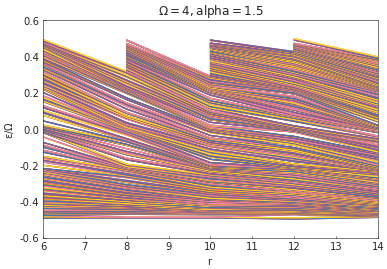

In [14]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.plot(r,qe(j+1))
plt.title('$\Omega=4,alpha = 1.5$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.show()

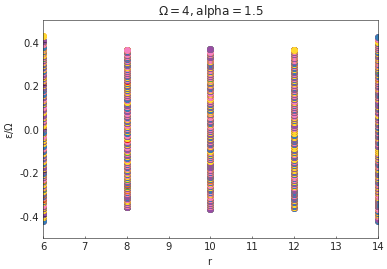

In [18]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.scatter(r,qe(j+1))
plt.title('$\Omega=4,alpha = 3$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.xlim(6,14)
plt.ylim(-0.5,0.5)
plt.show()

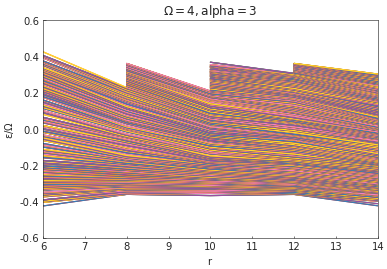

In [11]:
for j in range(np.size(quasi_energies_import[0])-1):
    plt.plot(r,qe(j+1))
plt.title('$\Omega=4,alpha = 3$')
plt.xlabel('$r$')
plt.ylabel('$\epsilon/\Omega$')
plt.show()